# Evaluating ROQ

**Comparing with 4 Baselines: Neo, Bao, Lero, Balsa**

**Using 3 Benchmarks: JOB, CEB, DSB**

In [689]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import torch
import pandas as pd
import numpy as np
# import pickle
# from torch_geometric.loader import DataLoader
from util.eval_util import describe_plot, plot_step_curve #, comput_uncertainty
# from util.util import set_seed
# from pyg_data import queryPlanPGDataset, queryPlanPGDataset_nosplit, queryPlanPGDataset_withbenchmark


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [690]:
plots_id = 'complete_5x3'
show_fig=True

In [691]:
import matplotlib.pyplot as plt
import pickle

In [692]:
def collect_res(res_dict):
    """ Collect results from a dictionary of dataframes.
    
    Args:
        res_dict: A dictionary of dataframes.
    Returns:
        A tuple of two DataFrames: the mean and variance of the data.
    """
    res_all = []
    for key in res_dict:
        res_all.append(res_dict[key].values)
    res_all = np.array(res_all)
    res_df = res_dict[0].copy()
    res_var_df = res_dict[0].copy()
    res_df.loc[:, :] = np.mean(res_all, axis=0)
    res_var_df.loc[:, :] = np.std(res_all, axis=0)
    return res_df, res_var_df

def simple_load_dfs(res_type, exp_id):
    """
    Load results for a single experiment.
    
    Args:
        res_type: The type of results to load.
        exp_id: The ID of the experiment.
    Returns:
        A tuple of two DataFrames: the mean and variance of the data. 
    """
    # Load results for each unique experiment.
    def load_res(exp_id):
        with open(f'../results/{res_type}_{exp_id}.pkl', 'rb') as file:
            return pickle.load(file)
    
    loaded = load_res(exp_id)
    
    return collect_res(loaded)

def load_dfs(res_type, model_exp_id):
    """
    Load results for multiple experiments.
    
    Args:
        res_type: The type of results to load.
        model_exp_id: A dictionary mapping model names to experiment IDs.
    Returns:
        A dictionary mapping experiment IDs to tuples of two DataFrames:
        the mean and variance of the data.
    """
    # Identify unique experiment IDs from the mapping.
    exp_ids = set(model_exp_id.values())
    
    # Load results for each unique experiment.
    loaded = {}
    def load_res(exp_id):
        with open(f'../results/{res_type}_{exp_id}.pkl', 'rb') as file:
            return pickle.load(file)
    
    for exp in exp_ids:
        loaded[exp] = load_res(exp)
    
    # Process each loaded result.
    processed = {}
    for exp, res in loaded.items():
        processed[exp] = collect_res(res)
    
    return processed

def stitch_res(res_type, model_exp_id):
    """
    Create a final stitched DataFrame (and corresponding variance DataFrame)
    using the following rules:
    
    - Every file contains all models.
    - For 'Neo', 'Bao', 'Lero', and 'Balsa', their data is pulled only from
      their corresponding files as given in model_exp_id.
    - Every other model (including 'Roq') is pulled from the file corresponding to 'Roq'
      (i.e. "job_main_1x_10kf_s312_kfoldcv").

    Args:
        res_type: The type of results to load.
        model_exp_id: A dictionary mapping model names to experiment IDs.
    Returns:
        A tuple of two DataFrames: the mean and variance of the data.
    """
    processed = load_dfs(res_type, model_exp_id)
    
    # Define the base experiment: the one corresponding to Roq.
    base_exp = model_exp_id['Roq']
    base_df, base_var_df = processed[base_exp]
    
    # For each model in the mapping, if its assigned experiment is not the base,
    # then override that model's data in the base DataFrame.
    for model, exp in model_exp_id.items():
        # Skip models whose file is the base file
        if exp == base_exp:
            continue
        
        # Get the override DataFrames from the experiment assigned to this model.
        override_df, override_var_df = processed[exp]
        
        # Define a helper to determine the effective name:
        def effective_label(labels, candidate):
            if candidate in labels:
                return candidate
            for alt in ['base_model', 'base model']:
                if alt in labels:
                    return alt
            return candidate  # fallback
        
        if res_type == 'agg_res_dict':
            # For aggregate results, model names are in the index.
            effective = effective_label(override_df.index, model)
            # Override the row in the base DataFrame.
            if effective in override_df.index:
                base_df.loc[model] = override_df.loc[effective]
                base_var_df.loc[model] = override_var_df.loc[effective]
        else:
            # For other results, model names are in the columns.
            effective = effective_label(override_df.columns, model)
            if effective in override_df.columns:
                base_df[model] = override_df[effective]
                base_var_df[model] = override_var_df[effective]
    
    # The final stitched DataFrames are taken from the base (with overrides applied).
    final_df = base_df
    final_var_df = base_var_df
    return final_df, final_var_df


In [ ]:

# exp_id = 'ceb-13k-500'
# exp_id = 'ceb_1000_x5'
# exp_id = 'ceb_1000_x3_s313'
# exp_id = 'ceb_1000_x5_s312'
exp_id = 'ceb_1000_x5_s310' # --> best so far - do not touch!
# exp_id = 'ceb_1000_x5_s317' # --> baseline are better
test_split = 'test'

model_exp_id = {
    'Bao':'ceb_1000_x5_s310_test',
    'Balsa':'ceb_1000_x5_s317_test',
    'Lero':'ceb_1000_x5_s310_test',
    'Neo':'ceb_1000_x5_s310_test',
    'Roq':'ceb_1000_x5_s310_test',
}

# Example usage:
qerror_all_df,qerror_all_var_df = stitch_res('qerror_dict',model_exp_id)
corr_all_df, corr_all_var_df = stitch_res('corr_dict',model_exp_id)
runtimes_all_df, runtimes_all_var_df = stitch_res('rt_res_dict',model_exp_id)
agg_res_all_df, agg_res_all_var_df = stitch_res('agg_res_dict',model_exp_id)
so_res_all_df, so_res_all_var_df = stitch_res('so_res_dict',model_exp_id)

In [694]:
exp_id = 'ceb_wlsh_baseline_x1_s313_benchmark'

ceb_wlsh_base_agg_res_all_df,ceb_wlsh_base_agg_res_all_var_df=simple_load_dfs('agg_res_dict',exp_id)
ceb_wlsh_base_runtimes_all_df,ceb_wlsh_base_runtimes_all_var_df=simple_load_dfs('rt_res_dict',exp_id)
ceb_wlsh_base_qerror_df, ceb_wlsh_base_qerror_var_df = simple_load_dfs('qerror_dict',exp_id)
ceb_wlsh_base_corr_df, ceb_wlsh_base_corr_var_df = simple_load_dfs('corr_dict',exp_id)

In [695]:
exp_id = 'ceb_wlsh_ood_x1_s313_benchmark'

ceb_wlsh_ood_runtimes_all_df,ceb_wlsh_ood_runtimes_all_var_df=simple_load_dfs('rt_res_dict',exp_id)
ceb_wlsh_ood_agg_res_all_df,ceb_wlsh_ood_agg_res_all_var_df=simple_load_dfs('agg_res_dict',exp_id)
ceb_wlsh_ood_qerror_df, ceb_wlsh_ood_qerror_var_df = simple_load_dfs('qerror_dict',exp_id)
ceb_wlsh_ood_corr_df, ceb_wlsh_ood_corr_var_df = simple_load_dfs('corr_dict',exp_id)

In [696]:
import pickle

# exp_id = 'ceb-13k-500'
# exp_id = 'ceb_1000'
# exp_id = 'ceb_1000_x3_s313'
# exp_id = 'ceb_1000_x5_s312'
# exp_id = 'ceb_1000_x5_s310'
# exp_id = 'ceb_1000_x5_s314'
exp_id = 'ceb_1000_x5_s315' # --> best so far
# exp_id = 'ceb_1000_x1_wlsh_ood_316'
test_split = 'benchmark'


model_exp_id = {
    'Bao':'ceb_1000_x5_s315_benchmark',
    'Balsa':'ceb_1000_x5_s315_benchmark',
    'Lero':'ceb_1000_x5_s315_benchmark',
    'Neo':'ceb_1000_x5_s315_benchmark',
    'Roq':'ceb_1000_x5_s315_benchmark',
}

job_qerror_all_df, job_qerror_all_var_df = stitch_res('qerror_dict',model_exp_id)
job_corr_all_df, job_corr_all_var_df = stitch_res('corr_dict',model_exp_id)
job_runtimes_all_df, job_runtimes_all_var_df = stitch_res('rt_res_dict',model_exp_id)
job_agg_res_all_df, job_agg_res_all_var_df = stitch_res('agg_res_dict',model_exp_id)
job_so_res_all_df, job_so_res_all_var_df = stitch_res('so_res_dict',model_exp_id)

In [811]:
# exp_id = 'job_main_5x_10kf_s313'
# exp_id = 'job_main_5x_10kf_s312' # <-- best so far
# exp_id = 'job_main_5x_10kf_s311'
# exp_id = 'job_main_1x_2kf_s313'
# exp_id = 'job_main_1x_10kf_s313' # <-- Bao and Balsa are better
# exp_id = 'job_main_1x_10kf_s316'
# test_split = 'kfoldcv'


model_exp_id = {
    'Bao':'job_main_5x_10kf_s313_kfoldcv',
    'Balsa':'job_main_1x_10kf_s316_kfoldcv',
    'Lero':'job_main_5x_10kf_s312_kfoldcv',
    'Neo':'job_main_5x_10kf_s311_kfoldcv',
    'Roq':'job_main_5x_10kf_s312_kfoldcv',
}

# Example usage:
job_main_qerror_all_df, job_main_qerror_all_var_df = stitch_res('qerror_dict',model_exp_id)
job_main_corr_all_df, job_main_corr_all_var_df = stitch_res('corr_dict',model_exp_id)
job_main_runtimes_all_df, job_main_runtimes_all_var_df = stitch_res('rt_res_dict',model_exp_id)
job_main_agg_res_all_df, job_main_agg_res_all_var_df = stitch_res('agg_res_dict',model_exp_id)
job_main_so_res_all_df, job_main_so_res_all_var_df = stitch_res('so_res_dict',model_exp_id)


/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
# tpcds_exp_id = 'dsb_1000_x1_s313_test'
# tpcds_exp_id = 'dsb_1000_x3_s313_test'
# tpcds_exp_id = 'dsb_1000_x5_s313' # --> secod best
exp_id = 'dsb_1000_x1_s313_test' # --> best so far
test_split = 'test'

tpcds_subopts_all_df,tpcds_subopts_all_var_df=simple_load_dfs('so_res_dict',exp_id)
tpcds_agg_res_all_df,tpcds_agg_res_all_var_df=simple_load_dfs('agg_res_dict',exp_id)
tpcds_runtimes_all_df,tpcds_runtimes_all_var_df=simple_load_dfs('rt_res_dict',exp_id)
tpcds_qerror_all_df,tpcds_qerror_all_var_df=simple_load_dfs('qerror_dict',exp_id)
tpcds_corr_all_df,tpcds_corr_all_var_df=simple_load_dfs('corr_dict',exp_id)



In [873]:
# remove rows with nans
tpcds_qerror_all_df = tpcds_qerror_all_df.dropna(axis=0)

In [699]:
# tpcds_exp_id = 'dsb_1000_x5_s313'
tpcds_exp_id = 'dsb_wlsh_baseline_x1_s313_benchmark' # --> best so far
# tpcds_exp_id = 'dsb_1000_x1_s313'


tpcds_ood_base_agg_res_all_df,tpcds_ood_base_agg_res_all_var_df=simple_load_dfs('agg_res_dict',tpcds_exp_id)
tpcds_ood_base_runtimes_all_df,tpcds_ood_base_runtimes_all_var_df=simple_load_dfs('rt_res_dict',tpcds_exp_id)
tpcds_ood_base_corr_df, tpcds_ood_base_corr_var_df = simple_load_dfs('corr_dict',tpcds_exp_id)
tpcds_ood_base_qerror_df, tpcds_ood_base_qerror_var_df = simple_load_dfs('qerror_dict',tpcds_exp_id)



In [700]:
# tpcds_exp_id = 'dsb_wlsh_x3_s313'
tpcds_exp_id = 'dsb_wlsh_ood_x1_s313'
test_split = 'benchmark'
exp_id = tpcds_exp_id+'_'+test_split

tpcds_ood_agg_res_all_df,tpcds_ood_agg_res_all_var_df=simple_load_dfs('agg_res_dict',exp_id)
tpcds_ood_runtimes_all_df,tpcds_ood_runtimes_all_var_df=simple_load_dfs('rt_res_dict',exp_id)
tpcds_ood_qerror_df, tpcds_ood_qerror_var_df = simple_load_dfs('qerror_dict',exp_id)
tpcds_ood_corr_df, tpcds_ood_corr_var_df = simple_load_dfs('corr_dict',exp_id)

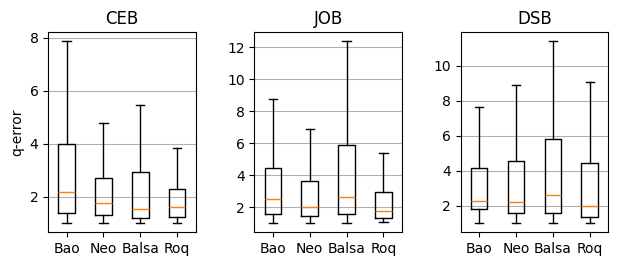

In [701]:
models = ['Bao','Neo','Balsa','Roq']

# qerror_all_df=qerror_all_df[models]
# job_main_qerror_all_df=job_main_qerror_all_df[models]
# tpcds_qerror_all_df=tpcds_qerror_all_df[models]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), sharey=False)
axs[0].boxplot(qerror_all_df[models], tick_labels=models, showfliers=False)
axs[0].set_title('CEB')
# axs[0].set_yscale('log')
axs[0].set_ylabel('q-error')
axs[0].grid(visible=True,which='both',axis='y')

axs[1].boxplot(job_main_qerror_all_df[models], tick_labels=models, showfliers=False)
axs[1].set_title('JOB')
# axs[1].set_yscale('log')
axs[1].grid(visible=True,which='both',axis='y')

axs[2].boxplot(tpcds_qerror_all_df[models], tick_labels=models, showfliers=False)
axs[2].set_title('DSB')
# axs[1].set_yscale('log')
axs[2].grid(visible=True,which='both',axis='y')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


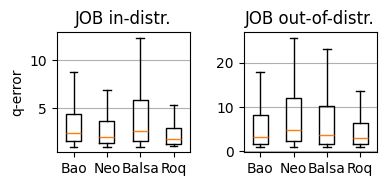

In [702]:
models = ['Bao','Neo','Balsa','Roq']

# job_main_qerror_all_df=job_main_qerror_all_df[models]
# job_qerror_all_df=job_qerror_all_df[models]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.5), sharey=False)
axs[0].boxplot(job_main_qerror_all_df[models], tick_labels=models, showfliers=False)
axs[0].set_title('JOB in-distr.')
# axs[0].set_yscale('log')
axs[0].set_ylabel('q-error')
axs[0].grid(visible=True,which='both',axis='y')

axs[1].boxplot(job_qerror_all_df[models], tick_labels=models, showfliers=False)
axs[1].set_title('JOB out-of-distr.')
# axs[1].set_yscale('log')
axs[1].grid(visible=True,which='both',axis='y')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

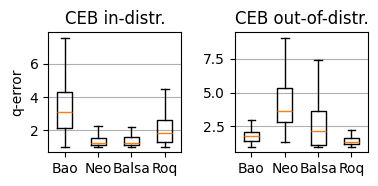

In [703]:
models = ['Bao','Neo','Balsa','Roq']

sub1=ceb_wlsh_base_qerror_df[models]
sub2=ceb_wlsh_ood_qerror_df[models]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.5), sharey=False)
axs[0].boxplot(sub1, tick_labels=models, showfliers=False)
axs[0].set_title('CEB in-distr.')
# axs[0].set_yscale('log')
axs[0].set_ylabel('q-error')
axs[0].grid(visible=True,which='both',axis='y')

axs[1].boxplot(sub2, tick_labels=models, showfliers=False)
axs[1].set_title('CEB out-of-distr.')
# axs[1].set_yscale('log')
axs[1].grid(visible=True,which='both',axis='y')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.savefig('./plots/ceb_wlsh_qerror_box_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

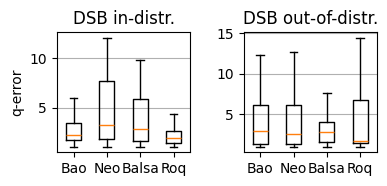

In [704]:
models = ['Bao','Neo','Balsa','Roq']

sub1=tpcds_ood_base_qerror_df[models]
sub2=tpcds_ood_qerror_df[models]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.5), sharey=False)
axs[0].boxplot(sub1, tick_labels=models, showfliers=False)
axs[0].set_title('DSB in-distr.')
# axs[0].set_yscale('log')
axs[0].set_ylabel('q-error')
axs[0].grid(visible=True,which='both',axis='y')

axs[1].boxplot(sub2, tick_labels=models, showfliers=False)
axs[1].set_title('DSB out-of-distr.')
# axs[1].set_yscale('log')
axs[1].grid(visible=True,which='both',axis='y')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.savefig('./plots/dsb_wlsh_qerror_box_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

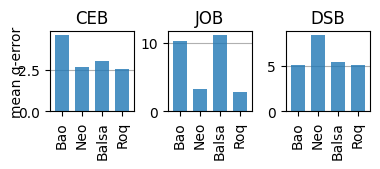

In [705]:
models = ['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4, 1), sharey=False)
y = qerror_all_df[models].mean(axis=0)
yerr = qerror_all_var_df[models].mean(axis=0)
y1 = job_main_qerror_all_df[models].mean(axis=0)
yerr1 = job_main_qerror_all_var_df[models].mean(axis=0)
y2 = tpcds_qerror_all_df[models].mean(axis=0)
yerr2 = tpcds_qerror_all_var_df[models].mean(axis=0)

ax =y.plot.bar(logy=False,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('CEB')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.tick_params(axis='x', rotation=90)

ax1 =y1.plot.bar(logy=False,
            #    yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('JOB')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)

ax2 =y2.plot.bar(logy=False,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[2])
ax2.set_title('DSB')
ax2.grid(visible=True,which='both',axis='y')
ax2.set_axisbelow(True)
ax2.tick_params(axis='x', rotation=90)
fig.supylabel('mean q-error',x=0, size=10)
# plt.text(x=-10.5,y=-14,s='(a)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.show()
plt.savefig('./plots/roq_neo_bao_ceb_job_tpcds_qerr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


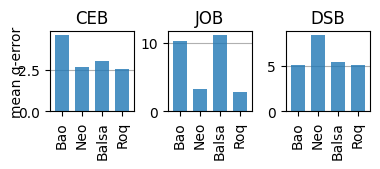

In [706]:
models = ['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4, 1), sharey=False)
y = qerror_all_df[models].mean(axis=0)
yerr = qerror_all_var_df[models].mean(axis=0)
y1 = job_main_qerror_all_df[models].mean(axis=0)
yerr1 = job_main_qerror_all_var_df[models].mean(axis=0)
y2 = tpcds_qerror_all_df[models].mean(axis=0)
yerr2 = tpcds_qerror_all_var_df[models].mean(axis=0)

ax =y.plot.bar(logy=False,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('CEB')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.tick_params(axis='x', rotation=90)

ax1 =y1.plot.bar(logy=False,
            #    yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('JOB')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)

ax2 =y2.plot.bar(logy=False,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[2])
ax2.set_title('DSB')
ax2.grid(visible=True,which='both',axis='y')
ax2.set_axisbelow(True)
ax2.tick_params(axis='x', rotation=90)
fig.supylabel('mean q-error',x=0, size=10)
# plt.text(x=-10.5,y=-14,s='(a)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.show()
plt.savefig('./plots/roq_neo_bao_ceb_job_tpcds_qerr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


In [707]:
percentiles = [.5,.75,.9,.95,.99]
qerror_all_df.describe(percentiles=percentiles).T

,count,mean,std,min,50%,75%,90%,95%,99%,max
Bao,1352.0,4.558440,13.376050,1.000866,2.167676,3.993363,9.605760,12.601298,18.256116,239.733246
Neo,1352.0,2.678471,3.238688,1.001115,1.745614,2.712251,4.523336,6.796571,17.712569,50.559555
Lero,1352.0,4.456494,8.708173,1.000680,2.780615,4.107677,7.016667,12.860318,28.620848,122.900276
Balsa,1352.0,3.039082,5.434025,1.000141,1.546890,2.944492,5.858950,9.099840,24.384150,93.927895
Roq,1352.0,2.539829,4.786630,1.001359,1.607063,2.293599,3.498413,6.275743,17.273766,77.549156
Roq MCDO,1352.0,2.542617,4.744065,1.000035,1.607568,2.291588,3.503293,6.583789,16.333447,82.200775


In [708]:
job_main_qerror_all_df.describe(percentiles=percentiles).T

,count,mean,std,min,50%,75%,90%,95%,99%,max
Bao,1469.0,10.186847,116.355293,1.000834,2.490270,4.443535,11.873047,21.508732,77.946194,4142.144043
Neo,1469.0,3.211559,3.621811,1.002169,2.006050,3.646676,6.348538,8.895133,17.350032,46.904842
Lero,1469.0,1.997824,20.839989,-277.444275,1.137603,3.031305,8.543254,19.940446,65.771695,173.808136
Balsa,1469.0,11.067770,39.823700,1.004026,2.651274,5.900857,15.465218,45.217592,180.656561,735.607056
Roq,1469.0,2.873432,3.049868,1.054675,1.787101,2.960320,5.833002,8.238370,17.547402,42.786232
Roq MCDO,1469.0,2.855203,2.970705,1.031182,1.791255,2.992456,5.955676,8.038023,15.244828,42.473263


In [709]:
tpcds_qerror_all_df.describe(percentiles=percentiles).T

,count,mean,std,min,50%,75%,90%,95%,99%,max
Bao,1058.0,5.160214,14.125696,1.000931,2.273280,4.157442,7.018073,9.838078,106.622439,150.277023
Neo,1058.0,8.387300,36.000565,1.002986,2.189215,4.528474,9.813545,16.977975,283.851390,401.056213
Lero,1058.0,-0.355755,0.973450,-7.148209,-0.015523,-0.004300,-0.000917,-0.000365,-0.000019,-0.000011
Balsa,1058.0,5.461513,13.460167,1.000053,2.614765,5.791136,7.568370,10.358362,104.683326,148.059387
Roq,1058.0,5.104665,15.477366,1.001251,2.002323,4.447456,7.313466,9.793482,121.652188,171.493195
Roq MCDO,1058.0,4.975925,13.941147,1.001026,2.098522,4.474924,7.696990,10.235193,102.217178,173.303665


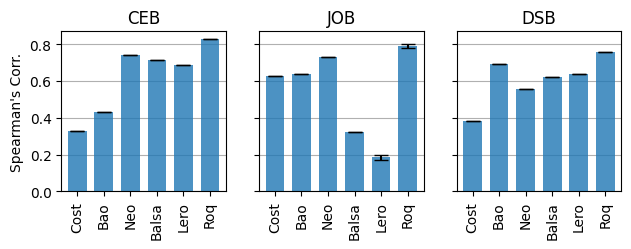

In [710]:
models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
logy=False

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharey=True)
y = corr_all_df.loc['Spearman',models]
yerr = corr_all_var_df.loc['Spearman',models]
y1 = job_main_corr_all_df.loc['Spearman',models]
yerr1 = job_main_corr_all_var_df.loc['Spearman',models]
y2 = tpcds_corr_all_df.loc['Spearman',models]
yerr2 = tpcds_corr_all_var_df.loc['Spearman',models]

ax =y.plot.bar(logy=logy,
               yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('CEB')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
ax.tick_params(axis='x', rotation=90)

ax1 =y1.plot.bar(logy=logy,
                yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('JOB')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)

ax2 =y2.plot.bar(logy=logy,
                yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[2])
ax2.set_title('DSB')
ax2.grid(visible=True,which='both',axis='y')
ax2.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)
# ax2.set_ylim(.25,.95)
# plt.text(x=-12,y=-.05,s='(b)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
# plt.show()
plt.savefig('./plots/roq_neo_bao_ceb_job_tpcds_corr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


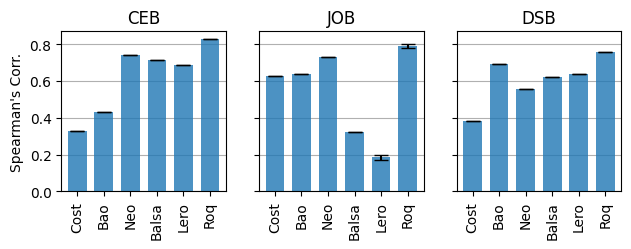

In [711]:
models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
logy=False

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharey=True)
y = corr_all_df.loc['Spearman',models]
yerr = corr_all_var_df.loc['Spearman',models]
y1 = job_main_corr_all_df.loc['Spearman',models]
yerr1 = job_main_corr_all_var_df.loc['Spearman',models]
y2 = tpcds_corr_all_df.loc['Spearman',models]
yerr2 = tpcds_corr_all_var_df.loc['Spearman',models]

ax =y.plot.bar(logy=logy,
               yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('CEB')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
ax.tick_params(axis='x', rotation=90)

ax1 =y1.plot.bar(logy=logy,
                yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('JOB')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)

ax2 =y2.plot.bar(logy=logy,
                yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[2])
ax2.set_title('DSB')
ax2.grid(visible=True,which='both',axis='y')
ax2.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=90)
# ax2.set_ylim(.25,.95)
# plt.text(x=-12,y=-.05,s='(b)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
# plt.show()
plt.savefig('./plots/roq_neo_bao_ceb_job_tpcds_corr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


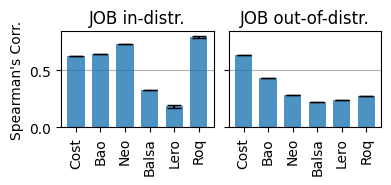

In [712]:
# models = ['Cost','Bao','Neo','Roq']
models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4,1.2), sharey=True)
y = job_main_corr_all_df.loc['Spearman',models]
yerr = job_main_corr_all_var_df.loc['Spearman',models]
y2 = job_corr_all_df.loc['Spearman',models]
yerr2 = job_corr_all_var_df.loc['Spearman',models]

ax =y.plot.bar(logy=False,
               yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('JOB in-distr.')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')

ax =y2.plot.bar(logy=False,yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax.set_title('JOB out-of-distr.')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)

plt.xticks(rotation=90,ha='center')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
plt.show()

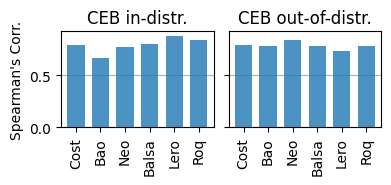

In [713]:
models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.2), sharey=True)
y = ceb_wlsh_base_corr_df.loc['Spearman',models]
yerr =  ceb_wlsh_base_corr_var_df.loc['Spearman',models]
y2 = ceb_wlsh_ood_corr_df.loc['Spearman',models]
yerr2 = ceb_wlsh_ood_corr_var_df.loc['Spearman',models]

ax =y.plot.bar(logy=False,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('CEB in-distr.')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
# ax.tick_params(axis='x', rotation=90)

ax1 =y2.plot.bar(logy=False,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('CEB out-of-distr.')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.tick_params(axis='x', rotation=90)


plt.xticks(rotation=90,ha='center')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
plt.savefig('./plots/corr_bar_dsb_wlsh_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

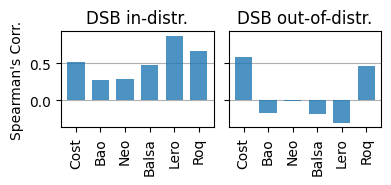

In [714]:
models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.2), sharey=True)
y = tpcds_ood_base_corr_df.loc['Spearman',models]
yerr =  tpcds_ood_base_corr_var_df.loc['Spearman',models]
y2 = tpcds_ood_corr_df.loc['Spearman',models]
yerr2 = tpcds_ood_corr_var_df.loc['Spearman',models]

ax =y.plot.bar(logy=False,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0])
ax.set_title('DSB in-distr.')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
# ax.tick_params(axis='x', rotation=90)

ax1 =y2.plot.bar(logy=False,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1])
ax1.set_title('DSB out-of-distr.')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.tick_params(axis='x', rotation=90)


plt.xticks(rotation=90,ha='center')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
plt.savefig('./plots/corr_bar_dsb_wlsh_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
# # tpcds_exp_id = 'dsb_1000_x1_s313_test'
# # tpcds_exp_id = 'dsb_1000_x3_s313_test'
# # tpcds_exp_id = 'dsb_1000_x5_s313' # --> secod best
# # exp_id = 'dsb_1000_x1_s313_test' # --> best so far

# exp_id = {
#     'Bao':'dsb_1000_x5_s313_test',
#     'Balsa':'dsb_1000_x5_s313_test',
#     'Lero':'dsb_1000_x5_s313_test',
#     'Neo':'dsb_1000_x5_s313_test',
#     'Roq':'dsb_1000_x5_s313_test',
# }

# tpcds_subopts_all_df,tpcds_subopts_all_var_df=stitch_res('so_res_dict',exp_id)
# tpcds_agg_res_all_df,tpcds_agg_res_all_var_df=stitch_res('agg_res_dict',exp_id)
# tpcds_runtimes_all_df,tpcds_runtimes_all_var_df=stitch_res('rt_res_dict',exp_id)
# tpcds_qerror_all_df,tpcds_qerror_all_var_df=stitch_res('qerror_dict',exp_id)
# tpcds_corr_all_df,tpcds_corr_all_var_df=stitch_res('corr_dict',exp_id)

# print(tpcds_qerror_all_df.isna().sum())
# tpcds_qerror_all_df = tpcds_qerror_all_df.dropna(axis=0)

Bao         0
Neo         0
Lero        0
Balsa       0
Roq         0
Roq MCDO    0
dtype: int64


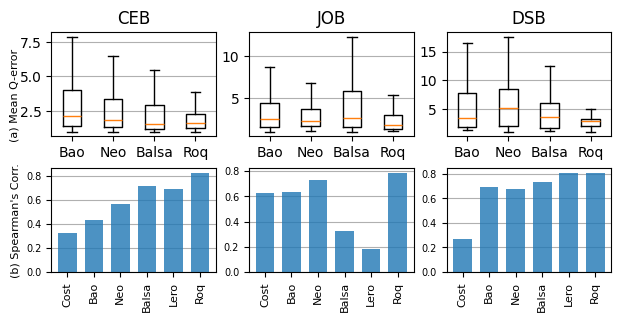

In [878]:
models = ['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), sharey=False, sharex=False)
y=qerror_all_df[models]
y1=job_main_qerror_all_df[models]
y2=tpcds_qerror_all_df[models]

ax0 = axs[0,0]
ax0.boxplot(y, tick_labels=models, showfliers=False)
ax0.set_title('CEB')
# ax0.set_yscale('log')
ax0.set_ylabel('(a) Mean Q-error',size=8)
ax0.yaxis.set_label_coords(-.19, .4)
ax0.grid(visible=True,which='both',axis='y')

ax1 = axs[0,1]
ax1.boxplot(y1, tick_labels=models, showfliers=False)
ax1.set_title('JOB')
# axs[1].set_yscale('log')
ax1.grid(visible=True,which='both',axis='y')

ax2 = axs[0,2]
ax2.boxplot(y2, tick_labels=models, showfliers=False)
ax2.set_title('DSB')
# axs[1].set_yscale('log')
ax2.grid(visible=True,which='both',axis='y')


models = ['Cost','Bao','Neo','Balsa','Lero','Roq']
logy=False

y = corr_all_df.loc['Spearman',models]
yerr = corr_all_var_df.loc['Spearman',models]
y1 = job_main_corr_all_df.loc['Spearman',models]
yerr1 = job_main_corr_all_var_df.loc['Spearman',models]
y2 = tpcds_corr_all_df.loc['Spearman',models]
yerr2 = tpcds_corr_all_var_df.loc['Spearman',models]

ax3 =y.plot.bar(logy=logy,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,0])
ax3.grid(visible=True,which='both',axis='y')
ax3.set_axisbelow(True)
ax3.set_ylabel('(b) Spearman\'s Corr.',size=8, )
ax3.tick_params(axis='x', rotation=90, labelsize=8)
ax3.tick_params(axis='y', labelsize=7)
# ax3.set_ylim(.25,1)

ax4 =y1.plot.bar(logy=logy,
                # yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,1])
ax4.grid(visible=True,which='both',axis='y')
ax4.set_axisbelow(True)
ax4.tick_params(axis='x', rotation=90, labelsize=8)
ax4.tick_params(axis='y', labelsize=7)
# ax4.set_ylim(.25,1)

ax5 =y2.plot.bar(logy=logy,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,2])
ax5.grid(visible=True,which='both',axis='y')
ax5.set_axisbelow(True)
ax5.tick_params(axis='x', rotation=90, labelsize=8)
ax5.tick_params(axis='y', labelsize=7)
# ax5.set_ylim(.25,1)
# plt.text(x=-10.5,y=-1,s='(a)',fontfamily='serif')
# plt.text(x=-12,y=-.05,s='(b)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
# plt.show()
plt.savefig('./plots/qerr_corr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


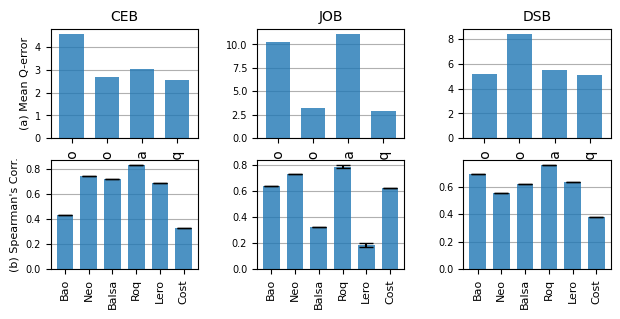

In [716]:
models = ['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), sharey=False, sharex=False)
y = qerror_all_df[models].mean(axis=0)
yerr = qerror_all_var_df[models].mean(axis=0)
y1 = job_main_qerror_all_df[models].mean(axis=0)
yerr1 = job_main_qerror_all_var_df[models].mean(axis=0)
y2 = tpcds_qerror_all_df[models].mean(axis=0)
yerr2 = tpcds_qerror_all_var_df[models].mean(axis=0)

ax =y.plot.bar(logy=False,
            #    yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0,0])
ax.set_title('CEB', fontsize=10)
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('(a) Mean Q-error',size=8)
ax.tick_params(axis='y', labelsize=7)

ax1 =y1.plot.bar(logy=False,
            #    yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0,1])
ax1.set_title('JOB', fontsize=10)
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
ax1.tick_params(axis='y', labelsize=7)

ax2 =y2.plot.bar(logy=False,
                # yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[0,2])
ax2.set_title('DSB', fontsize=10)
ax2.grid(visible=True,which='both',axis='y')
ax2.set_axisbelow(True)
ax2.tick_params(axis='y', labelsize=7)

models = ['Bao','Neo','Balsa','Roq','Lero','Cost']
logy=False

y = corr_all_df.loc['Spearman',models]
yerr = corr_all_var_df.loc['Spearman',models]
y1 = job_main_corr_all_df.loc['Spearman',models]
yerr1 = job_main_corr_all_var_df.loc['Spearman',models]
y2 = tpcds_corr_all_df.loc['Spearman',models]
yerr2 = tpcds_corr_all_var_df.loc['Spearman',models]

ax3 =y.plot.bar(logy=logy,
               yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,0])
ax3.grid(visible=True,which='both',axis='y')
ax3.set_axisbelow(True)
ax3.set_ylabel('(b) Spearman\'s Corr.',size=8, )
ax3.tick_params(axis='x', rotation=90, labelsize=8)
ax3.tick_params(axis='y', labelsize=7)
# ax3.set_ylim(.25,1)

ax4 =y1.plot.bar(logy=logy,
                yerr=yerr1.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,1])
ax4.grid(visible=True,which='both',axis='y')
ax4.set_axisbelow(True)
ax4.tick_params(axis='x', rotation=90, labelsize=8)
ax4.tick_params(axis='y', labelsize=7)
# ax4.set_ylim(.25,1)

ax5 =y2.plot.bar(logy=logy,
                yerr=yerr2.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7, ax=axs[1,2])
ax5.grid(visible=True,which='both',axis='y')
ax5.set_axisbelow(True)
ax5.tick_params(axis='x', rotation=90, labelsize=8)
ax5.tick_params(axis='y', labelsize=7)
# ax5.set_ylim(.25,1)
# plt.text(x=-10.5,y=-1,s='(a)',fontfamily='serif')
# plt.text(x=-12,y=-.05,s='(b)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)
# plt.show()
plt.savefig('./plots/qerr_corr_bar_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


In [717]:
cons_qerror = pd.DataFrame([job_main_qerror_all_df.mean(axis=0),job_qerror_all_df.mean(axis=0)]).T
cons_qerror_var = pd.DataFrame([np.sqrt(job_main_qerror_all_var_df).mean(axis=0),np.sqrt(job_qerror_all_var_df).mean(axis=0)]).T
cons_qerror.columns = ['Baseline','Workload Shift']
cons_qerror_var.columns = ['Baseline','Workload Shift']
cons_qerror

,Baseline,Workload Shift
Bao,10.186847,28.258678
Neo,3.211559,22.862513
Lero,1.997824,-1.824773
Balsa,11.067770,19.771191
Roq,2.873432,10.005273
Roq MCDO,2.855203,10.145601


In [718]:
tpcds_cons_qerror = pd.DataFrame([tpcds_ood_base_qerror_df.mean(axis=0),tpcds_ood_qerror_df.mean(axis=0)]).T
tpcds_cons_qerror_var = pd.DataFrame([np.sqrt(tpcds_ood_base_qerror_var_df).mean(axis=0),np.sqrt(tpcds_ood_qerror_var_df).mean(axis=0)]).T
tpcds_cons_qerror.columns = ['Baseline','Workload Shift']
tpcds_cons_qerror_var.columns = ['Baseline','Workload Shift']
tpcds_cons_qerror

,Baseline,Workload Shift
Bao,3.198159,5.690923
Neo,4.908854,5.139643
Lero,-0.049943,13.152314
Balsa,3.999763,4.479742
Roq,2.501035,4.249352
Roq MCDO,2.477061,4.315608


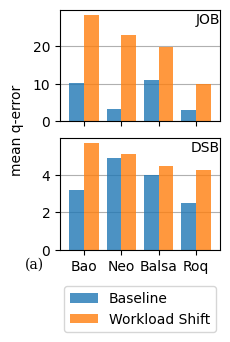

In [719]:
labels=['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2, 3), sharex=True)

ax =cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[0],
    legend=False
    )
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
# ax.set_ylim(0,27)
# ax.right_ax.set_ylim(0,27)
ax.set_title('JOB',fontsize=10,loc = 'right',y=.8)

ax1 =tpcds_cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[1],
    legend=False
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.set_ylim(0,6)
# ax1.right_ax.set_ylim(0,6)
ax1.set_title('DSB',fontsize=10,loc = 'right',y=.8)

lhandles, llabels = ax1.get_legend_handles_labels()
# rhandles, rlabels = ax1.right_ax.get_legend_handles_labels()
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -.8), ncol=1)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.15)
plt.text(x=-1.6,y=-1,s='(a)',fontfamily='serif')

fig.supylabel('mean q-error',x=-.15, size=10)
plt.savefig('./plots/qerror_bar_ood_v_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
# plt.show()

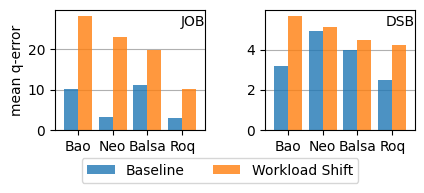

In [720]:
labels=['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 1.5), sharex=True)

ax =cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[0],
    legend=False
    )
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
# ax.set_ylim(0,12)
# ax.right_ax.set_ylim(0,12)
ax.set_title('JOB',fontsize=10,loc = 'right',y=.8)

ax1 =tpcds_cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[1],
    legend=False
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.set_ylim(0,6)
# ax1.right_ax.set_ylim(0,6)
ax1.set_title('DSB',fontsize=10,loc = 'right',y=.8)

lhandles, llabels = ax1.get_legend_handles_labels()
# rhandles, rlabels = ax1.right_ax.get_legend_handles_labels()
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(-0.3, -0.5), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.15)
# plt.text(x=-1.6,y=-23,s='(a)',fontfamily='serif')

fig.supylabel('mean q-error',x=0, size=10)
plt.savefig('./plots/qerror_bar_ood_h_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
# plt.show()

In [721]:
cons_corr = pd.DataFrame([job_main_corr_all_df.T.Spearman,job_corr_all_df.T.Spearman]).T
cons_corr_var = pd.DataFrame([np.sqrt(job_main_corr_all_var_df).T.Spearman,np.sqrt(job_corr_all_var_df).T.Spearman]).T
cons_corr.columns = ['Baseline','Workload Shift']
cons_corr_var.columns = ['Baseline','Workload Shift']
cons_corr

,Baseline,Workload Shift
Cost,0.625462,0.634711
Bao,0.636963,0.434318
Neo,0.729381,0.283320
Lero,0.184652,0.241593
Balsa,0.322775,0.224782
Roq,0.787512,0.278221
Roq MCDO,0.786961,0.299667


In [722]:
tpcds_cons_corr = pd.DataFrame([tpcds_ood_base_corr_df.mean(axis=0),tpcds_ood_corr_df.mean(axis=0)]).T
tpcds_cons_corr_var = pd.DataFrame([np.sqrt(tpcds_ood_base_corr_var_df).mean(axis=0),np.sqrt(tpcds_ood_corr_var_df).mean(axis=0)]).T
tpcds_cons_corr.columns = ['Baseline','Workload Shift']
tpcds_cons_corr_var.columns = ['Baseline','Workload Shift']
tpcds_cons_corr

,Baseline,Workload Shift
Cost,0.303911,0.359248
Bao,0.216495,-0.192736
Neo,0.155944,-0.117369
Lero,0.774869,-0.267471
Balsa,0.297915,-0.202441
Roq,0.617081,0.382302
Roq MCDO,0.634199,0.257804


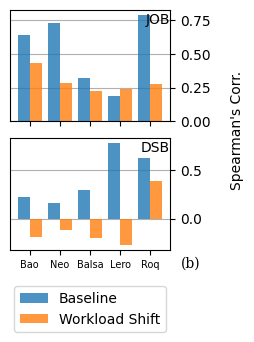

In [723]:
labels=['Bao','Neo','Balsa','Lero','Roq']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2, 3), sharex=True)

ax =cons_corr.loc[labels].plot.bar(
    logy=False,
    # yerr=cons_corr_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[0],
    legend=False
    )
ax.grid(visible=True,which='both',axis='y')
# ax.set_ylim(0,1)
# ax.right_ax.set_ylim(0,.7)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.set_title('JOB',fontsize=10,loc = 'right',y=.8)

ax1 =tpcds_cons_corr.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_corr_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[1],
    legend=False
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center',fontsize=7)
ax1.grid(visible=True,which='both',axis='y')
# ax1.set_ylim(0,.7)
# ax1.right_ax.set_ylim(0,.7)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_axisbelow(True)
ax1.set_title('DSB',fontsize=10,loc = 'right',y=.8)



lhandles, llabels = ax1.get_legend_handles_labels()
# ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -.7), ncol=2)
# rhandles, rlabels = ax1.right_ax.get_legend_handles_labels()
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -.8), ncol=1)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.15)
plt.text(x=5,y=-.5,s='(b)',fontfamily='serif')

fig.supylabel('Spearman\'s Corr.',x=1.2, size=10)
# legend.remove()
plt.savefig('./plots/corr_bar_ood_v_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

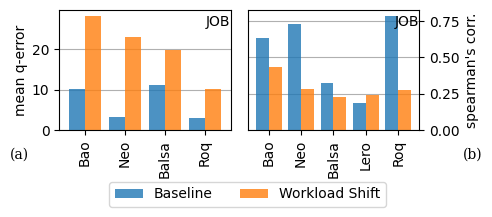

In [724]:
labels=['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 1.5), sharex=False)

ax =cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[0],
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=90,ha='center')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
# ax.set_ylim(0,6)
# ax.right_ax.set_ylim(0,6)
ax.set_title('JOB',fontsize=10,loc = 'right',y=.8)


labels = ['Bao','Neo','Balsa','Lero','Roq']
ax1 = cons_corr.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_corr_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[1],
    legend=False
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=90,ha='center')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.set_ylim(0,6)
# ax1.right_ax.set_ylim(0,6)
ax1.set_ylabel('spearman\'s corr.')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_title('JOB',fontsize=10,loc = 'right',y=.8)

lhandles, llabels = ax1.get_legend_handles_labels()
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(0, -0.7), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.15)
plt.text(x=-8,y=-0.2,s='(a)',fontfamily='serif')
plt.text(x=6,y=-0.2,s='(b)',fontfamily='serif')

fig.supylabel('mean q-error',x=0, size=10)
plt.savefig('./plots/qerr_corr_job_bar_ood_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
# plt.show()

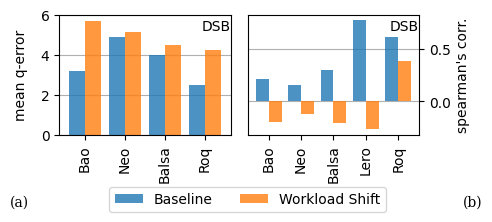

In [725]:
labels=['Bao','Neo','Balsa','Roq']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 1.5), sharex=False)

ax =tpcds_cons_qerror.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_qerror_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[0],
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=90,ha='center')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylim(0,6)
# ax.right_ax.set_ylim(0,6)
ax.set_title('DSB',fontsize=10,loc = 'right',y=.8)


labels = ['Bao','Neo','Balsa','Lero','Roq']
ax1 = tpcds_cons_corr.loc[labels].plot.bar(
    logy=False,
    # yerr=tpcds_cons_corr_var.loc[labels].T.values,
    # secondary_y = 'Workload Shift',
    align='center', alpha=0.8, ecolor='black', 
    capsize=2.5, width=0.8, ax = axs[1],
    legend=False
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=90,ha='center')
ax1.grid(visible=True,which='both',axis='y')
ax1.set_axisbelow(True)
# ax1.set_ylim(0,6)
# ax1.right_ax.set_ylim(0,6)
ax1.set_ylabel('spearman\'s corr.')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_title('DSB',fontsize=10,loc = 'right',y=.8)

lhandles, llabels = ax1.get_legend_handles_labels()
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(0, -0.7), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.15)
plt.text(x=-8,y=-1,s='(a)',fontfamily='serif')
plt.text(x=6,y=-1,s='(b)',fontfamily='serif')

fig.supylabel('mean q-error',x=0, size=10)
plt.savefig('./plots/qerr_corr_dsb_bar_ood_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
# plt.show()

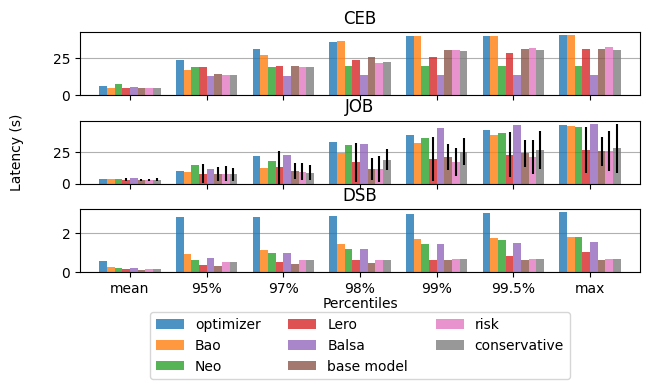

In [726]:
models = [
    'optimizer',
    'Bao', 'Neo', 
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]
percentiles = [.5,.75,.85,.95,.97,.98,.99,.995]
labels = ['mean','95%','97%','98%','99%','99.5%','max']
rename = {'50%':'median', '95%':'95', '99%':'99', '99.5%':'99.5'}
logy=False

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 3), sharex=True)

sub = runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub_var = runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub1 = job_main_runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub_var1 = job_main_runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub2 = tpcds_runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub2_var = tpcds_runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]

ax = sub.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[0], legend=False,
    yerr=sub_var,
    width=.8,
    )

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB')
# ax.set_ylim(0,65)
# ax.right_ax.set_ylabel('99th Perc. Subopt')

ax1 = sub1.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[1], legend=False,
    yerr=sub_var1,
    width=.8
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB')
# ax1.set_ylim(0,65)

ax2 = sub2.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[2], legend=False,
    yerr=sub2_var,
    width=.8
    )
ax2.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB')
# ax2.set_ylim(0,85)

# ax2.right_ax.set_ylabel('99th Perc. Subopt')

lhandles, llabels = ax.get_legend_handles_labels()
# llabels[-1]= 'Roq'
ax2.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.8), ncol=3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.supylabel('Latency (s)',x=0,size=10)
fig.supxlabel('Percentiles',y=-.03,size=10)
# plt.savefig('./plots/subopt_bar_main_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

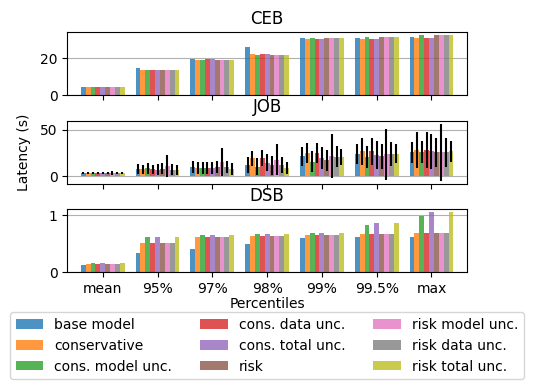

In [727]:
models = [
   'base model',
   'conservative',
   'cons. prun. model unc. RN',
   'cons. prun. data unc. RN',
   'cons. prun. RN',
   'risk',
   'risk prun. model unc. RN', 
   'risk prun. data unc. RN', 
   'risk prun. RN', 
   ]

chart_labels = [
   'base model',
   'conservative',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]
percentiles = [.5,.75,.85,.95,.97,.98,.99,.995]
labels = ['mean','95%','97%','98%','99%','99.5%','max']
# rename = {'50%':'median', '95%':'95th', '99%':'99th'}
logy=False

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 3), sharex=True)

sub = runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub_var = runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub1 = job_main_runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub_var1 = job_main_runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub2 = tpcds_runtimes_all_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]
sub2_var = tpcds_runtimes_all_var_df.loc[:,models].describe(percentiles = percentiles).loc[labels,:]

ax = sub.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[0], legend=False,
    yerr=sub_var,
    width=.8,
    )

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB')
# ax.set_ylim(0,65)
# ax.right_ax.set_ylabel('99th Perc. Subopt')

ax1 = sub1.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[1], legend=False,
    yerr=sub_var1,
    width=.8
    )
ax1.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB')
# ax1.set_ylim(0,65)

ax2 = sub2.plot.bar(
    align='center', alpha=0.8,
    logy=logy,
    ax = axs[2], legend=False,
    yerr=sub2_var,
    width=.8
    )
ax2.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=0,ha='center')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB')
# ax2.set_ylim(0,85)

# ax2.right_ax.set_ylabel('99th Perc. Subopt')

lhandles, llabels = ax.get_legend_handles_labels()
# rhandles, rlabels = ax.right_ax.get_legend_handles_labels()
ax2.legend(lhandles, chart_labels, loc='lower center', bbox_to_anchor=(.5, -1.8), ncol=3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.supylabel('Latency (s)',x=0,size=10)
fig.supxlabel('Percentiles',y=-.03,size=10)
# plt.savefig('./plots/subopt_bar_main_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

In [728]:
def plot_split_bar(df,df_var,lower_range,upper_range,plot_title,axs,logy=False, plot_var=False):
    ax=df.plot.bar(
        logy=logy,
        # secondary_y=['99th'],
        yerr=df_var if plot_var else None,
        align='center', alpha=0.8, ecolor='black', 
        capsize=1.5, width=0.75,ax=axs[0],
        legend=False
        )

    ax1=df.plot.bar(
        logy=logy,
        # secondary_y=['99th'],
        yerr=df_var if plot_var else None,
        align='center', alpha=0.8, ecolor='black', 
        capsize=1.5, width=0.75,ax=axs[1],
        legend=False
        )

    ax.grid(visible=True,which='major',axis='y')
    ax1.grid(visible=True,which='major',axis='y')
    ax.set_axisbelow(True)
    ax.set_title(plot_title,fontsize=10,loc='right',y=0)

    ax.set_ylim(upper_range[0], upper_range[1])  # outliers only
    ax1.set_ylim(lower_range[0], lower_range[1])  # most of the data

    # hide the spines between ax and ax2
    ax.spines.bottom.set_color('grey')
    ax1.spines.top.set_color('grey')
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax1.xaxis.tick_bottom()

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
    ax1.plot([0, 1], [1, 1], transform=ax1.transAxes, **kwargs)
    return ax, ax1

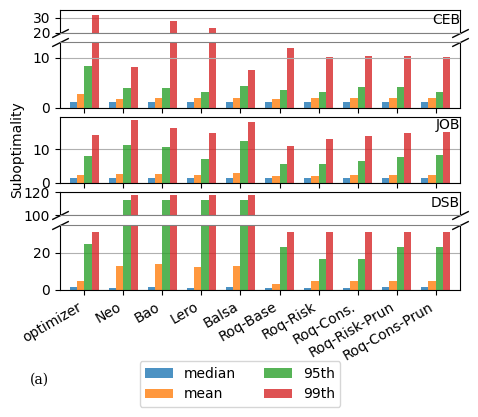

In [812]:
labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    'cons. prun. SO',
    # 'risk prun. RN',
    'risk prun. SO'
    ]

chart_labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Risk',
    'Roq-Cons.',
    'Roq-Risk-Prun',
    'Roq-Cons-Prun',
]

plot_var = False

rename = {'mean':'mean','50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False
cols = list(rename.keys())

sub = agg_res_all_df.loc[labels,cols].copy()
sub_var = agg_res_all_var_df.loc[labels,cols].copy()
sub.rename(rename,axis=1,inplace=True)
sub_var.rename(rename,axis=1,inplace=True)

sub1 = job_main_agg_res_all_df.loc[labels,cols].copy()
sub_var1 = job_main_agg_res_all_var_df.loc[labels,cols].copy()
sub1.rename(rename,axis=1,inplace=True)
sub_var1.rename(rename,axis=1,inplace=True)

sub2 = tpcds_agg_res_all_df.loc[labels,cols].copy()
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,cols].copy()
sub2.rename(rename,axis=1,inplace=True)
sub_var2.rename(rename,axis=1,inplace=True)


height_ratios = [0.7,2,2,0.7,2]
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax,ax1=plot_split_bar(
    sub.loc[labels,data_points],
    sub_var.loc[labels,data_points] if plot_var else None,
    lower_range=[0, 13], upper_range=[20, 35],
    plot_title='CEB',axs=axs[0:2],logy=logy, plot_var=plot_var
    )

ax2=sub1.loc[labels,data_points].plot.bar(
    logy=logy, 
    # secondary_y=['99th'],
    yerr=sub_var1.loc[labels,data_points] if plot_var else None,
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[2],
    legend=False
    )
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('JOB',fontsize=10,loc='right',y=.7)

ax3,ax4=plot_split_bar(
    sub2.loc[labels,data_points],
    sub_var2.loc[labels,data_points] if plot_var else None,
    lower_range=[0, 35], upper_range=[100, 120],
    plot_title='DSB',axs=axs[3:5],logy=logy, plot_var=plot_var
    )

ax4.set_xticks(ticks=np.arange(len(labels)),labels=chart_labels,rotation=30,ha='right')
ax4.grid(visible=True,which='major',axis='y')
ax4.set_axisbelow(True)
# ax4.set_title('DSB',fontsize=10,loc='right',y=.7)

lhandles, llabels = ax4.get_legend_handles_labels()
ax4.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.45, -1.9), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)
plt.text(x=-1.4,y=-50,s='(a)',fontfamily='serif')
# plt.tight_layout()
fig.supylabel('Suboptimality',x=0,size=10)

plt.savefig('./plots/subopt_bar_main_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [730]:
agg_res_all_df.index

Index(['Balsa', 'Bao', 'Lero', 'Neo', 'base model', 'base model pruned',
       'best', 'cons. data unc.', 'cons. model unc.', 'cons. prun. RN',
       'cons. prun. SO', 'cons. prun. data unc. RN',
       'cons. prun. data unc. SO', 'cons. prun. model unc. RN',
       'cons. prun. model unc. SO', 'conservative', 'mc dropout',
       'mc dropout pruned', 'optimizer', 'optimizer pruned', 'risk',
       'risk data unc.', 'risk model unc.', 'risk prun. RN', 'risk prun. SO',
       'risk prun. data unc. RN', 'risk prun. data unc. SO',
       'risk prun. model unc. RN', 'risk prun. model unc. SO'],
      dtype='object')

In [731]:
labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    'base model pruned',
    'conservative',
    'cons. model unc.',
    'cons. data unc.',
    # 'cons. prun. model unc. SO',
    # 'cons. prun. data unc. SO',
    'cons. prun. SO',
    'risk',
    'risk model unc.',
    'risk data unc.',
    # 'risk prun. model unc. SO', 
    # 'risk prun. data unc. SO', 
    'risk prun. SO',
    ]
chart_labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Base-Prun',
    'Roq-Cons',
    'Roq-Cons-Model',
    'Roq-Cons-Data',
    # 'Roq-Cons-Prun-Model',
    # 'Roq-Cons-Prun-Data',
    'Roq-Cons-Prun',
    'Roq-Risk',
    'Roq-Risk-Model',
    'Roq-Risk-Data',
    # 'Roq-Risk-Prun-Model',
    # 'Roq-Risk-Prun-Data',
    'Roq-Risk-Prun',
]



rename = {'mean':'mean','50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False
cols = list(rename.keys())
sub = agg_res_all_df.loc[labels,cols].copy()
sub.rename(rename,axis=1,inplace=True)
sub.index = chart_labels

sub1 = job_main_agg_res_all_df.loc[labels,cols].copy()
sub1.rename(rename,axis=1,inplace=True)
sub1.index = chart_labels

sub2 = tpcds_agg_res_all_df.loc[labels,cols].copy()
sub2.rename(rename,axis=1,inplace=True)
sub2.index = chart_labels

output_for_paper = pd.concat((sub,sub1,sub2),axis=1,keys=['CEB','JOB','DSB'])
output_for_paper

CEB                                      JOB            \
                    mean    median      95th       99th      mean    median   
optimizer       2.821203  1.133255  8.245210  31.615361  2.276110  1.438025   
Neo             1.683700  1.148098  3.886616   8.082176  2.663809  1.375165   
Bao             1.934212  1.046470  3.942853  27.963618  2.272163  1.281113   
Lero            1.941759  1.068510  3.058239  22.971056  2.299627  1.422176   
Balsa           1.975703  1.131129  4.273272   7.564951  2.846430  1.534590   
Roq-Base        1.820719  1.087764  3.437915  11.990779  2.093998  1.358522   
Roq-Base-Prun   1.820719  1.087764  3.437915  11.990779  2.932409  1.509251   
Roq-Cons        1.933723  1.054354  4.041127  10.363719  2.184501  1.349494   
Roq-Cons-Model  1.891660  1.070383  3.158786  10.138052  2.169822  1.279449   
Roq-Cons-Data   1.933723  1.054354  4.041127  10.363719  2.205861  1.350223   
Roq-Cons-Prun   1.933843  1.054354  4.041127  10.363719  2.325033  1.344124   
Roq-Risk        1.894749  1.077495  3.158786  10.138052  2.091517  1.287741   
Roq-Risk-Model  1.892059  1.064936  3.158786  10.138052  2.145696  1.284042   
Roq-Risk-Data   1.894749  1.077495  3.158786  10.138052  2.091396  1.287741   
Roq-Risk-Prun   1.894749  1.077495  3.158786  10.138052  2.341377  1.318583   

                                            DSB                        \
                     95th       99th       mean    median        95th   
optimizer        8.121413  14.162995   4.966256  1.363561   24.414725   
Neo             11.167477  18.675584  12.617396  1.248814  112.891199   
Bao              7.336623  18.962293  14.023962  1.370556  112.891199   
Lero             7.184972  14.947765  12.408408  1.286202  112.891199   
Balsa           12.652903  18.293352  12.926894  1.375472  112.891199   
Roq-Base         5.693964  11.070468   3.114420  1.278665   22.998775   
Roq-Base-Prun   11.521073  19.645355  13.478425  1.513011  112.891199   
Roq-Cons         6.493120  14.047090   5.077550  1.116068   16.800367   
Roq-Cons-Model   7.426871  14.053421   8.019523  1.161736   19.083039   
Roq-Cons-Data    6.620827  14.545493   5.077550  1.116068   16.800367   
Roq-Cons-Prun    7.780301  15.038279   5.022490  1.440670   22.983631   
Roq-Risk         5.733185  13.010141   5.077455  1.116068   16.800367   
Roq-Risk-Model   6.652449  13.755358   6.229640  1.143123   19.048078   
Roq-Risk-Data    5.733185  13.010141   5.077455  1.116068   16.800367   
Roq-Risk-Prun    8.265798  15.223397   5.017387  1.427571   22.983631   

                            
                      99th  
optimizer        31.172418  
Neo             117.827536  
Bao             117.827536  
Lero            117.827536  
Balsa           117.827536  
Roq-Base         31.172418  
Roq-Base-Prun   117.827536  
Roq-Cons         31.054539  
Roq-Cons-Model  208.144418  
Roq-Cons-Data    31.054539  
Roq-Cons-Prun    31.053525  
Roq-Risk         31.054539  
Roq-Risk-Model  110.934194  
Roq-Risk-Data    31.054539  
Roq-Risk-Prun    31.053525

In [732]:
labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    'base model pruned',
    'conservative',
    'cons. model unc.',
    'cons. data unc.',
    # 'cons. prun. model unc. SO',
    # 'cons. prun. data unc. SO',
    'cons. prun. SO',
    'risk',
    'risk model unc.',
    'risk data unc.',
    # 'risk prun. model unc. SO', 
    # 'risk prun. data unc. SO', 
    'risk prun. SO',
    ]
chart_labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Base-Prun',
    'Roq-Cons',
    'Roq-Cons-Model',
    'Roq-Cons-Data',
    # 'Roq-Cons-Prun-Model',
    # 'Roq-Cons-Prun-Data',
    'Roq-Cons-Prun',
    'Roq-Risk',
    'Roq-Risk-Model',
    'Roq-Risk-Data',
    # 'Roq-Risk-Prun-Model',
    # 'Roq-Risk-Prun-Data',
    'Roq-Risk-Prun',
]



rename = {'mean':'mean','50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False
cols = list(rename.keys())
sub = ceb_wlsh_ood_agg_res_all_df.loc[labels,cols].copy()
sub.rename(rename,axis=1,inplace=True)
sub.index = chart_labels

sub1 = job_agg_res_all_df.loc[labels,cols].copy()
sub1.rename(rename,axis=1,inplace=True)
sub1.index = chart_labels

sub2 = tpcds_ood_agg_res_all_df.loc[labels,cols].copy()
sub2.rename(rename,axis=1,inplace=True)
sub2.index = chart_labels

output_for_paper_wlsh = pd.concat((sub,sub1,sub2),axis=1,keys=['CEB','JOB','DSB'])
output_for_paper_wlsh

CEB                                       JOB            \
                    mean    median       95th       99th      mean    median   
optimizer       1.166413  1.027903   1.840452   2.859032  2.388470  1.530251   
Neo             1.151979  1.090050   1.594879   1.814220  2.775956  1.504609   
Bao             1.212630  1.086376   1.860145   2.871290  2.524561  1.501512   
Lero            1.202106  1.098985   1.711289   2.871290  1.979654  1.450017   
Balsa           1.161387  1.018244   1.849303   2.859032  2.855822  1.319392   
Roq-Base        1.158554  1.054803   1.438751   2.679099  2.145641  1.460313   
Roq-Base-Prun   5.433348  4.260258  10.536457  19.644684  2.105020  1.454658   
Roq-Cons        1.126777  1.102635   1.271843   1.804720  2.196760  1.441808   
Roq-Cons-Model  1.139169  1.099187   1.441757   1.799457  2.196760  1.441808   
Roq-Cons-Data   1.126777  1.102635   1.271843   1.804720  2.196760  1.441808   
Roq-Cons-Prun   1.126777  1.102635   1.271843   1.804720  2.198721  1.441808   
Roq-Risk        1.129307  1.086376   1.438403   1.796187  2.019223  1.416092   
Roq-Risk-Model  1.133026  1.086376   1.441757   1.790924  2.202247  1.437011   
Roq-Risk-Data   1.129307  1.086376   1.438403   1.796187  2.017422  1.416092   
Roq-Risk-Prun   1.159613  1.140248   1.473793   1.848281  2.237635  1.387515   

                                           DSB                                  
                     95th       99th      mean    median       95th       99th  
optimizer        7.690384  15.872310  1.178115  1.099967   1.565128   2.112522  
Neo             11.055402  18.928647  5.136062  1.541871  13.650218  16.993569  
Bao              8.287169  18.962293  4.783609  1.618295  12.596274  33.928990  
Lero             4.455730   8.970171  2.217318  1.448325   4.332417   7.189256  
Balsa           13.169305  19.709278  2.211852  1.658015   4.152104   7.169030  
Roq-Base         4.696813  17.293262  3.734344  1.420322  12.818503  15.061392  
Roq-Base-Prun    4.447924  17.293262  4.294292  1.536714  12.169791  19.539355  
Roq-Cons         5.874288  17.752878  4.577518  1.662369  12.725302  18.371870  
Roq-Cons-Model   5.874288  17.752878  4.152643  1.606311  12.401527  24.278625  
Roq-Cons-Data    5.874288  17.752878  4.644826  1.666440  12.725302  18.371870  
Roq-Cons-Prun    5.874288  17.752878  4.488385  1.498787  12.723970  16.404144  
Roq-Risk         3.448378  16.476858  4.559061  1.666440  12.848222  18.371870  
Roq-Risk-Model   5.874288  18.888970  4.412447  1.639224  12.798351  24.278625  
Roq-Risk-Data    3.448378  16.476858  4.559061  1.666440  12.848222  18.371870  
Roq-Risk-Prun    5.874288  18.888970  4.316380  1.392429  12.781479  16.404144

In [733]:
sub1

,mean,median,95th,99th
optimizer,2.388470,1.530251,7.690384,15.872310
Neo,2.775956,1.504609,11.055402,18.928647
Bao,2.524561,1.501512,8.287169,18.962293
Lero,1.979654,1.450017,4.455730,8.970171
Balsa,2.855822,1.319392,13.169305,19.709278
Roq-Base,2.145641,1.460313,4.696813,17.293262
Roq-Base-Prun,2.105020,1.454658,4.447924,17.293262
Roq-Cons,2.196760,1.441808,5.874288,17.752878
Roq-Cons-Model,2.196760,1.441808,5.874288,17.752878
Roq-Cons-Data,2.196760,1.441808,5.874288,17.752878


In [734]:
sub2

,mean,median,95th,99th
optimizer,1.178115,1.099967,1.565128,2.112522
Neo,5.136062,1.541871,13.650218,16.993569
Bao,4.783609,1.618295,12.596274,33.928990
Lero,2.217318,1.448325,4.332417,7.189256
Balsa,2.211852,1.658015,4.152104,7.169030
Roq-Base,3.734344,1.420322,12.818503,15.061392
Roq-Base-Prun,4.294292,1.536714,12.169791,19.539355
Roq-Cons,4.577518,1.662369,12.725302,18.371870
Roq-Cons-Model,4.152643,1.606311,12.401527,24.278625
Roq-Cons-Data,4.644826,1.666440,12.725302,18.371870


In [735]:
def compare(sub,data_points,model1='Roq-Base',model2='optimizer'):
    res = (sub.loc[model1,data_points]-sub.loc[model2,data_points])/sub.loc[model2,data_points]
    # print(res)
    return res

In [736]:
def compare_all(subs,data_points,model1='Roq-Base',model2='optimizer'):
    results=[]
    for sets in subs:
        results.append(compare(sets,data_points,model1,model2)) 
    mean = pd.DataFrame(results).mean(axis=0).sort_values()
    return mean

In [737]:
res = compare_all(
    [sub,sub1,sub2],
    data_points,
    model1='Roq-Base',
    model2='optimizer')
res

median    0.090569
mean      0.687119
99th      2.052056
95th      2.194180
dtype: float64

In [738]:
for model in sub.index:
    print(model)
    res = compare_all([sub,sub1,sub2],data_points,model1='Roq-Base',model2=model)
    print("base model vs. {}".format(model))
    print(res)
    print()

optimizer
base model vs. optimizer
median    0.090569
mean      0.687119
99th      2.052056
95th      2.194180
dtype: float64

Neo
base model vs. Neo
95th     -0.244660
mean     -0.164757
median   -0.046869
99th      0.092208
dtype: float64

Bao
base model vs. Bao
99th     -0.237015
95th     -0.214046
mean     -0.138011
median   -0.059612
dtype: float64

Lero
base model vs. Lero
median   -0.017479
mean      0.243930
95th      0.617863
99th      0.651971
dtype: float64

Balsa
base model vs. Balsa
median   -0.000216
mean      0.145739
99th      0.305126
95th      0.407292
dtype: float64

Roq-Base
base model vs. Roq-Base
median    0.0
mean      0.0
95th      0.0
99th      0.0
dtype: float64

Roq-Base-Prun
base model vs. Roq-Base-Prun
99th     -0.364266
mean     -0.299289
median   -0.274754
95th     -0.251396
dtype: float64

Roq-Cons
base model vs. Roq-Cons
mean     -0.059756
median   -0.058716
95th     -0.020629
99th      0.092805
dtype: float64

Roq-Cons-Model
base model vs. Roq-Cons-Mod

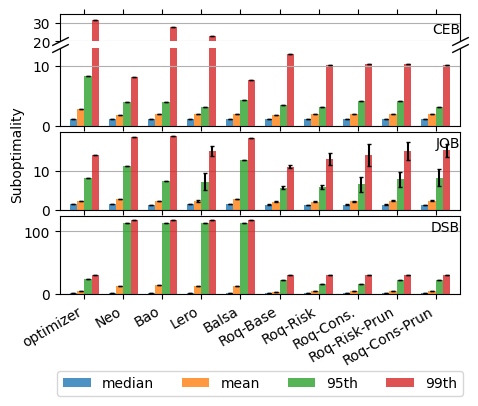

In [739]:
labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    'cons. prun. SO',
    # 'risk prun. RN',
    'risk prun. SO'
    ]
chart_labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Risk',
    'Roq-Cons.',
    'Roq-Risk-Prun',
    'Roq-Cons-Prun',
]


rename = {'mean':'mean','50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False
cols = list(rename.keys())
sub = agg_res_all_df.loc[labels,cols].copy()
sub_var = agg_res_all_var_df.loc[labels,cols].copy()
sub.rename(rename,axis=1,inplace=True)
sub_var.rename(rename,axis=1,inplace=True)

sub1 = job_main_agg_res_all_df.loc[labels,cols].copy()
sub_var1 = job_main_agg_res_all_var_df.loc[labels,cols].copy()
sub1.rename(rename,axis=1,inplace=True)
sub_var1.rename(rename,axis=1,inplace=True)

sub2 = tpcds_agg_res_all_df.loc[labels,cols].copy()
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,cols].copy()
sub2.rename(rename,axis=1,inplace=True)
sub_var2.rename(rename,axis=1,inplace=True)


height_ratios = [0.7,2,2,2]
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[0],
    legend=False
    )

ax1=sub.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[1],
    legend=False
    )

ax.grid(visible=True,which='major',axis='y')
ax1.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB',fontsize=10,loc='right',y=0)

ax.set_ylim(20, 35)  # outliers only
ax1.set_ylim(0, 13)  # most of the data

# hide the spines between ax and ax2
ax.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax1.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
ax1.plot([0, 1], [1, 1], transform=ax1.transAxes, **kwargs)

ax2=sub1.loc[labels,data_points].plot.bar(
    logy=logy, 
    # secondary_y=['99th'],
    yerr=sub_var1.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[2],
    legend=False
    )
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('JOB',fontsize=10,loc='right',y=.7)


ax3=sub2.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var2.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[3],
    legend=False
    )
ax3.set_xticks(ticks=np.arange(len(labels)),labels=chart_labels,rotation=30,ha='right')
ax3.grid(visible=True,which='major',axis='y')
ax3.set_axisbelow(True)
ax3.set_title('DSB',fontsize=10,loc='right',y=.7)

lhandles, llabels = ax3.get_legend_handles_labels()
ax3.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.4), ncol=4)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
# plt.text(x=-1.4,y=-180,s='(a)',fontfamily='serif')
# plt.tight_layout()
fig.supylabel('Suboptimality',x=0,size=10)

plt.savefig('./plots/subopt_bar_main_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

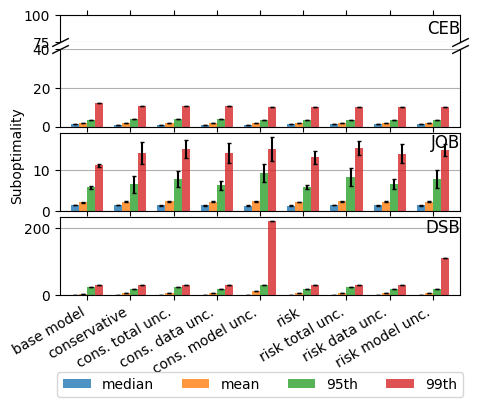

In [740]:
labels = [
    'base model',
    'conservative',
    'cons. prun. SO',
    'cons. prun. data unc. SO',
    'cons. prun. model unc. SO',
    'risk',
    'risk prun. SO', 
    'risk prun. data unc. SO', 
    'risk prun. model unc. SO', 
    ]

chart_labels = [
    'base model',
    'conservative',
    'cons. total unc.',
    'cons. data unc.',
    'cons. model unc.',
    'risk',
    'risk total unc.',
    'risk data unc.',
    'risk model unc.'
    ]

rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False

sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]
sub.rename(rename,axis=1,inplace=True)
sub_var.rename(rename,axis=1,inplace=True)

sub1 = job_main_agg_res_all_df.loc[labels,:]
sub_var1 = job_main_agg_res_all_var_df.loc[labels,:]
sub1.rename(rename,axis=1,inplace=True)
sub_var1.rename(rename,axis=1,inplace=True)

sub2 = tpcds_agg_res_all_df.loc[labels,:]
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,:]
sub2.rename(rename,axis=1,inplace=True)
sub_var2.rename(rename,axis=1,inplace=True)


height_ratios = [0.7,2,2,2]
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[0],
    legend=False
    )

ax1=sub.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[1],
    legend=False
    )

ax.grid(visible=True,which='major',axis='y')
ax1.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB',loc='right',y=0)

ax.set_ylim(75, 100)  # outliers only
ax1.set_ylim(0, 40)  # most of the data

# hide the spines between ax and ax2
ax.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax1.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
ax1.plot([0, 1], [1, 1], transform=ax1.transAxes, **kwargs)

ax2=sub1.loc[labels,data_points].plot.bar(
    logy=logy, 
    # secondary_y=['99th'],
    yerr=sub_var1.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[2],
    legend=False
    )
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('JOB',loc='right',y=.7)


ax3=sub2.loc[labels,data_points].plot.bar(
    logy=logy,
    # secondary_y=['99th'],
    yerr=sub_var2.loc[labels,data_points],
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,ax=axs[3],
    legend=False
    )
ax3.set_xticks(ticks=np.arange(len(chart_labels)),labels=chart_labels,rotation=30,ha='right')
ax3.grid(visible=True,which='major',axis='y')
ax3.set_axisbelow(True)
ax3.set_title('DSB',loc='right',y=.7)

lhandles, llabels = ax3.get_legend_handles_labels()
ax3.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.4), ncol=4)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
# plt.tight_layout()
fig.supylabel('Suboptimality',x=0,size=10)

plt.savefig('./plots/subopt_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [741]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
   #  'cons. prun. RN',
    # 'cons. prun. SO',
   #  'risk prun. RN',
    # 'risk prun. SO'
    ]
tpcds_agg_res_all_df.loc[labels,:].head(10)

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,total_subopt,mean,50%,60%,70%,80%,90%,95%,99%,max
Neo,0.288462,45.842508,1.528084,0.269231,10.389652,0.371059,0.442308,-0.616292,-35.452856,-0.340893,0.383708,12.617396,1.248814,1.472587,2.669652,8.711693,26.050935,112.891199,117.827536,130.638948
Bao,0.365385,45.704982,1.202763,0.413462,18.650166,0.433725,0.221154,-0.470305,-27.054816,-0.260142,0.529695,14.023962,1.370556,2.046493,10.082488,12.300132,26.623562,112.891199,117.827536,130.638948
Lero,0.250000,45.548961,1.751883,0.355769,4.922910,0.133052,0.394231,-0.706219,-40.626051,-0.390635,0.293781,12.408408,1.286202,1.398372,1.531858,2.394389,28.628634,112.891199,117.827536,130.638948
Balsa,0.259615,45.626413,1.689867,0.432692,10.567686,0.234837,0.307692,-0.609440,-35.058727,-0.337103,0.390560,12.926894,1.375472,1.530164,2.068661,10.007284,28.628634,112.891199,117.827536,130.638948
base model,0.375000,45.723442,1.172396,0.201923,1.552473,0.073927,0.423077,-0.767842,-44.170969,-0.424721,0.232158,3.114420,1.278665,1.398372,1.513680,1.574216,2.685971,22.998775,31.172418,35.262821
risk,0.548077,45.815182,0.803775,0.201923,3.914493,0.186404,0.250000,-0.728377,-41.900689,-0.402891,0.271623,5.077455,1.116068,1.220159,1.354016,1.527182,10.904169,16.800367,31.054539,220.956819
conservative,0.548077,45.815182,0.803775,0.211538,3.914896,0.177950,0.240385,-0.728370,-41.900285,-0.402887,0.271630,5.077550,1.116068,1.220159,1.354016,1.527182,10.904169,16.800367,31.054539,220.956819


In [742]:
sub_var

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,total_subopt,mean,median,60%,70%,80%,90%,95th,99th,max
base model,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
conservative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cons. prun. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cons. prun. data unc. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cons. prun. model unc. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
risk prun. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
risk prun. data unc. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
risk prun. model unc. SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


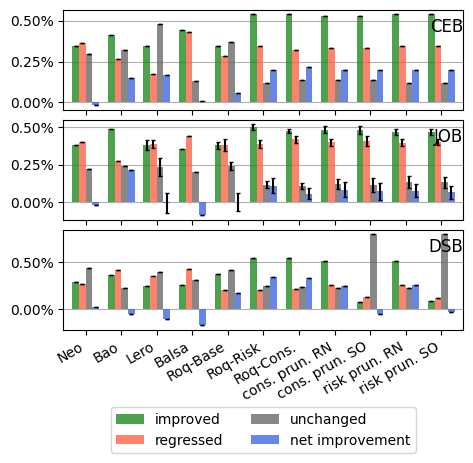

In [743]:
import matplotlib.ticker as mtick

labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    'cons. prun. RN',
    'cons. prun. SO',
    'risk prun. RN',
    'risk prun. SO'
    ]
chart_labels = [
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Risk',
    'Roq-Cons.',
    'cons. prun. RN',
    'cons. prun. SO',
    'risk prun. RN',
    'risk prun. SO'
]

features = ["improved","regressed","unchanged"]

sub = agg_res_all_df.loc[labels,features]
sub["net improvement"] = sub["improved"]-sub["regressed"]
sub_var = agg_res_all_var_df.loc[labels,features]
sub_var["net improvement"] = sub_var["improved"]+sub_var["regressed"]

sub1 = job_main_agg_res_all_df.loc[labels,features]
sub1["net improvement"] = sub1["improved"]-sub1["regressed"]
sub_var1 = job_main_agg_res_all_var_df.loc[labels,features]
sub_var1["net improvement"] = sub_var1["improved"]+sub_var1["regressed"]

sub2 = tpcds_agg_res_all_df.loc[labels,features]
sub2["net improvement"] = sub2["improved"]-sub2["regressed"]
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,features]
sub_var2["net improvement"] = sub_var2["improved"]+sub_var2["regressed"]

features+=["net improvement"]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 4), sharex=True)


ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[0])
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB',loc='right',y=.7)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var1.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[1])
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB',loc='right',y=.7)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2 = sub2.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var2.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[2])
ax2.set_xticks(ticks=np.arange(len(labels)),labels=chart_labels,rotation=30,ha='right')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB',loc='right',y=.7)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

lhandles, llabels = ax2.get_legend_handles_labels()
llabels = ["improved","regressed","unchanged","net improvement"]
ax2.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.3), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
plt.savefig('./plots/runtime_bar_alt_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [744]:
sub

,improved,regressed,unchanged,net improvement
Neo,0.343137,0.362745,0.294118,-0.019608
Bao,0.411765,0.264706,0.323529,0.147059
Lero,0.343137,0.176471,0.480392,0.166667
Balsa,0.441176,0.431373,0.127451,0.009804
base model,0.343137,0.284314,0.372549,0.058824
risk,0.539216,0.343137,0.117647,0.196078
conservative,0.539216,0.323529,0.137255,0.215686
cons. prun. RN,0.529412,0.333333,0.137255,0.196078
cons. prun. SO,0.529412,0.333333,0.137255,0.196078
risk prun. RN,0.539216,0.343137,0.117647,0.196078


In [819]:

# exp_id = 'ceb-13k-500'
# exp_id = 'ceb_1000_x5'
# exp_id = 'ceb_1000_x3_s313'
# exp_id = 'ceb_1000_x5_s312'
exp_id = 'ceb_1000_x5_s310' # --> best so far - do not touch!
# exp_id = 'ceb_1000_x5_s317' # --> baseline are better
test_split = 'test'

model_exp_id = {
    'Bao':'ceb_1000_x5_s310_test',
    'Balsa':'ceb_1000_x5_s317_test',
    'Lero':'ceb_1000_x5_s310_test',
    'Neo':'ceb_1000_x5_s310_test',
    'Roq':'ceb_1000_x5_s310_test',
}

# Example usage:
qerror_all_df,qerror_all_var_df = stitch_res('qerror_dict',model_exp_id)
corr_all_df, corr_all_var_df = stitch_res('corr_dict',model_exp_id)
runtimes_all_df, runtimes_all_var_df = stitch_res('rt_res_dict',model_exp_id)
agg_res_all_df, agg_res_all_var_df = stitch_res('agg_res_dict',model_exp_id)
so_res_all_df, so_res_all_var_df = stitch_res('so_res_dict',model_exp_id)

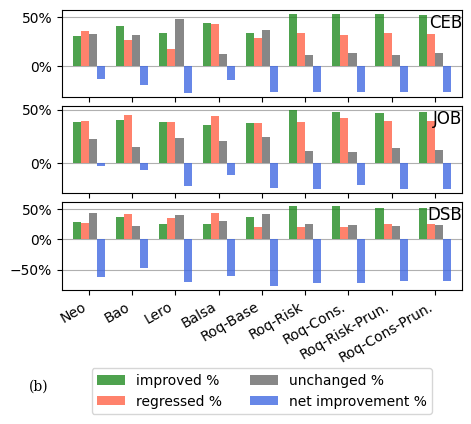

In [820]:
import matplotlib.ticker as mtick

labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'base model pruned',
    'risk prun. RN',
    # 'risk prun. SO',
    'cons. prun. RN',
    # 'cons. prun. SO',

    ]
chart_labels = [
    'Neo','Bao',
    'Lero','Balsa',
    'Roq-Base',
    'Roq-Risk',
    'Roq-Cons.',
    # 'Roq-Base-Prun.',
    'Roq-Risk-Prun.',
    'Roq-Cons-Prun.',

]

features = ["improved","regressed","unchanged","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]*100
sub_var = agg_res_all_var_df.loc[labels,features]*100

sub1 = job_main_agg_res_all_df.loc[labels,features]*100
sub_var1 = job_main_agg_res_all_var_df.loc[labels,features]*100

sub2 = tpcds_agg_res_all_df.loc[labels,features]*100
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,features]*100


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 3.5), sharex=True)


ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            # yerr=sub_var.loc[:,features],
            align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[0])
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB',loc='right',y=.7)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            # yerr=sub_var1.loc[:,features],
            align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[1])
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB',loc='right',y=.7)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2 = sub2.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            # yerr=sub_var2.loc[:,features],
            align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[2])
ax2.set_xticks(ticks=np.arange(len(labels)),labels=chart_labels,rotation=30,ha='right')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB',loc='right',y=.7)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

lhandles, llabels = ax2.get_legend_handles_labels()
llabels = ["improved %","regressed %","unchanged %","net improvement %"]
ax2.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.5), ncol=2)

plt.text(x=-1.4,y=-250,s='(b)',fontfamily='serif')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
plt.savefig('./plots/runtime_bar_alt2_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [746]:
sub

,improved,regressed,unchanged,total_runtime_change%
Neo,34.313725,36.274510,29.411765,-5.524699
Bao,41.176471,26.470588,32.352941,-19.397485
Lero,34.313725,17.647059,48.039216,-28.137215
Balsa,44.117647,43.137255,12.745098,-14.530855
base model,34.313725,28.431373,37.254902,-26.937985
risk,53.921569,34.313725,11.764706,-27.366305
conservative,53.921569,32.352941,13.725490,-27.299843
risk prun. RN,53.921569,34.313725,11.764706,-27.366305
cons. prun. RN,52.941176,33.333333,13.725490,-27.253813


In [747]:
sub1

,improved,regressed,unchanged,total_runtime_change%
Neo,38.053097,39.823009,22.123894,-3.123643
Bao,48.672566,27.433628,23.893805,-28.210812
Lero,38.053097,38.584071,23.362832,-21.041134
Balsa,35.398230,44.247788,20.353982,-11.573263
base model,37.876106,37.876106,24.247788,-23.156213
risk,49.734513,38.761062,11.504425,-24.555186
conservative,47.433628,41.769912,10.796460,-20.605979
risk prun. RN,46.902655,39.469027,13.628319,-24.755371
cons. prun. RN,48.141593,39.823009,12.035398,-24.317503


In [748]:
sub2

,improved,regressed,unchanged,total_runtime_change%
Neo,28.846154,26.923077,44.230769,-61.629170
Bao,36.538462,41.346154,22.115385,-47.030508
Lero,25.000000,35.576923,39.423077,-70.621948
Balsa,25.961538,43.269231,30.769231,-60.944039
base model,37.500000,20.192308,42.307692,-76.784227
risk,54.807692,20.192308,25.000000,-72.837706
conservative,54.807692,21.153846,24.038462,-72.837003
risk prun. RN,51.923077,25.961538,22.115385,-69.298458
cons. prun. RN,50.961538,25.961538,23.076923,-69.759228


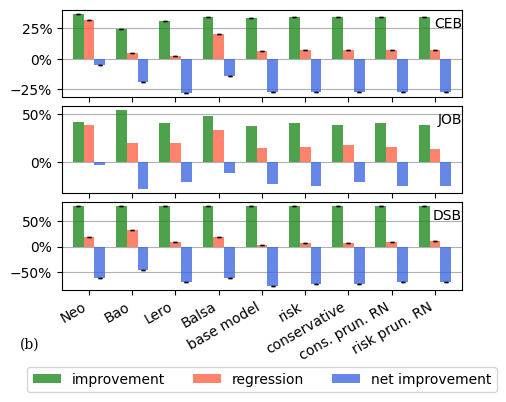

In [749]:
import matplotlib.ticker as mtick

labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
   #  'mc dropout',
    'risk',
    'conservative',
    'cons. prun. RN',
   #  'cons. prun. SO',
    'risk prun. RN',
   #  'risk prun. SO'
    ]

features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]
sub_perc = sub.copy()
sub_var_perc=sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub1 = job_main_agg_res_all_df.loc[labels,features]
sub_var1 = job_main_agg_res_all_var_df.loc[labels,features]
sub_perc1 = sub1.copy()
sub_var_perc1=sub_var1.copy()
sub_perc1[["improved_runtime","regressed_runtime"]] = sub_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_var_perc1[["improved_runtime","regressed_runtime"]] = sub_var_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_perc1=sub_perc1*100
sub_var_perc1=sub_var_perc1*100

sub2 = tpcds_agg_res_all_df.loc[labels,features]
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,features]
sub_perc2 = sub2.copy()
sub_var_perc2=sub_var2.copy()
sub_perc2[["improved_runtime","regressed_runtime"]] = sub_perc2[["improved_runtime","regressed_runtime"]]/tpcds_runtimes_all_df.optimizer.sum()
sub_var_perc2[["improved_runtime","regressed_runtime"]] = sub_var_perc2[["improved_runtime","regressed_runtime"]]/tpcds_runtimes_all_df.optimizer.sum()
sub_perc2=sub_perc2*100
sub_var_perc2=sub_var_perc2*100


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 3.5), sharex=True)

ax = sub_perc.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB',fontsize=10,loc='right',y=.7)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_ylabel('%')

ax1 = sub_perc1.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], #yerr=sub_var_perc1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])

ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB',fontsize=10,loc='right',y=.7)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax1.set_ylabel('%')

ax2 = sub_perc2.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc2,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[2])
ax2.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB',fontsize=10,loc='right',y=.7)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax2.set_ylabel('%')

lhandles, llabels = ax2.get_legend_handles_labels()
llabels = ["improvement","regression","net improvement"]
ax2.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.25), ncol=3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
plt.text(x=-1.6,y=-200,s='(b)',fontfamily='serif')
# plt.show()
plt.savefig('./plots/runtime_bar_main_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)


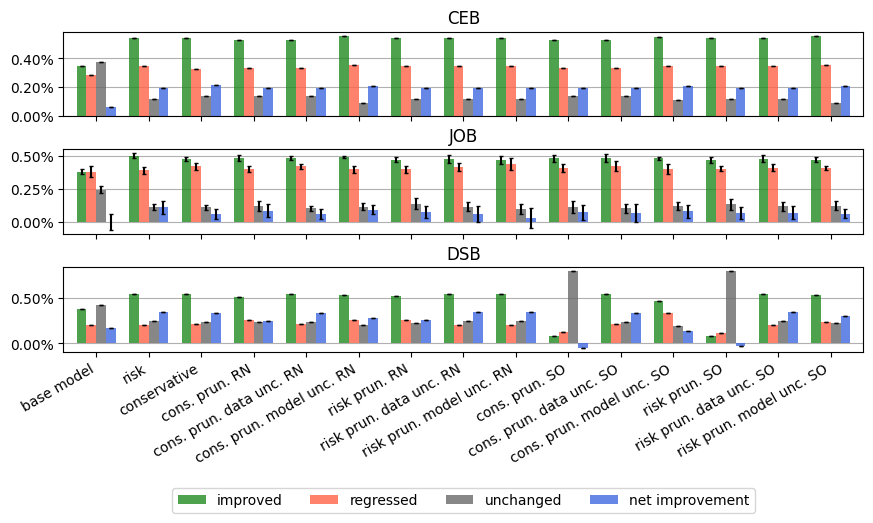

In [750]:
import matplotlib.ticker as mtick

labels = [
   'base model',
   'risk',
   'conservative',
   'cons. prun. RN',
   'cons. prun. data unc. RN',
   'cons. prun. model unc. RN',
   'risk prun. RN', 
   'risk prun. data unc. RN', 
   'risk prun. model unc. RN',
   'cons. prun. SO',
   'cons. prun. data unc. SO',
   'cons. prun. model unc. SO',
   'risk prun. SO', 
   'risk prun. data unc. SO', 
   'risk prun. model unc. SO', 
   ]

chart_labels = labels.copy()

features = ["improved","regressed","unchanged"]

sub = agg_res_all_df.loc[labels,features]
sub["net improvement"] = sub["improved"]-sub["regressed"]
sub_var = agg_res_all_var_df.loc[labels,features]
sub_var["net improvement"] = sub_var["improved"]+sub_var["regressed"]

sub1 = job_main_agg_res_all_df.loc[labels,features]
sub1["net improvement"] = sub1["improved"]-sub1["regressed"]
sub_var1 = job_main_agg_res_all_var_df.loc[labels,features]
sub_var1["net improvement"] = sub_var1["improved"]+sub_var1["regressed"]

sub2 = tpcds_agg_res_all_df.loc[labels,features]
sub2["net improvement"] = sub2["improved"]-sub2["regressed"]
sub_var2 = tpcds_agg_res_all_var_df.loc[labels,features]
sub_var2["net improvement"] = sub_var2["improved"]+sub_var2["regressed"]

features+=["net improvement"]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 4), sharex=True)


ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[0])
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var1.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[1])
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2 = sub2.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var2.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5,width=0.75, legend = False, ax = axs[2])
ax2.set_xticks(ticks=np.arange(len(labels)),labels=chart_labels,rotation=30,ha='right')
ax2.grid(visible=True,which='major',axis='y')
ax2.set_axisbelow(True)
ax2.set_title('DSB')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

lhandles, llabels = ax2.get_legend_handles_labels()
# llabels = ["improved","regressed","unchanged","net improvement"]
ax2.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -2), ncol=4)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [751]:
sub2

,improved,regressed,unchanged,net improvement
base model,0.375000,0.201923,0.423077,0.173077
risk,0.548077,0.201923,0.250000,0.346154
conservative,0.548077,0.211538,0.240385,0.336538
cons. prun. RN,0.509615,0.259615,0.230769,0.250000
cons. prun. data unc. RN,0.548077,0.211538,0.240385,0.336538
cons. prun. model unc. RN,0.538462,0.259615,0.201923,0.278846
risk prun. RN,0.519231,0.259615,0.221154,0.259615
risk prun. data unc. RN,0.548077,0.201923,0.250000,0.346154
risk prun. model unc. RN,0.548077,0.201923,0.250000,0.346154
cons. prun. SO,0.076923,0.125000,0.798077,-0.048077


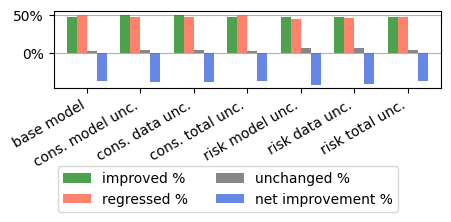

In [752]:
labels = [
   'base model',
   'cons. prun. model unc. RN',
   'cons. prun. data unc. RN',
   'cons. prun. RN',
   'risk prun. model unc. RN', 
   'risk prun. data unc. RN', 
   'risk prun. RN', 
   ]

chart_labels = [
   'base model',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]

features = ["improved","regressed","unchanged","total_runtime_change%"]
plot_var = False
sub = job_agg_res_all_df.loc[labels,features]*100
sub_var = job_agg_res_all_var_df.loc[labels,features]*100

sub.index=chart_labels
sub_var.index=chart_labels

# sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub.plot.bar(logy=False,figsize=[5,1],
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            yerr=sub_var if plot_var else None,
            align='center', alpha=0.8, ecolor='black', capsize=1.5, width=.75)
plt.xticks(rotation=30,ha='right')
ax.grid(visible=True,which='both',axis='y')
# ax.set_ylim((-55,60))
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

lhandles, llabels = ax.get_legend_handles_labels()
llabels = ["improved %","regressed %","unchanged %","net improvement %"]
ax.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.45, -1.7), ncol=2)
# plt.text(x=-1.8,y=-205,s='(b)',fontfamily='serif')

# plt.show()
plt.savefig('./plots/tpcds_runtime_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)

In [753]:
sub

,improved,regressed,unchanged,total_runtime_change%
base model,47.787611,49.557522,2.654867,-37.149982
cons. model unc.,49.557522,46.902655,3.539823,-37.850768
cons. data unc.,49.557522,46.902655,3.539823,-37.850768
cons. total unc.,46.902655,50.442478,2.654867,-36.021231
risk model unc.,47.787611,45.132743,7.079646,-41.244592
risk data unc.,47.787611,46.017699,6.194690,-40.711004
risk total unc.,47.787611,47.787611,4.424779,-36.877701


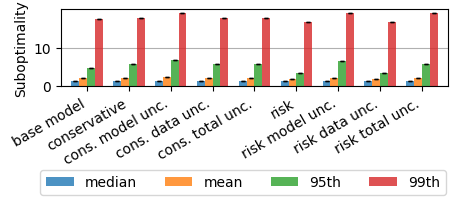

In [754]:
labels = [
   'base model',
   'conservative',
   'cons. prun. model unc. SO',
   'cons. prun. data unc. SO',
   'cons. prun. SO',
   'risk',
   'risk prun. model unc. SO', 
   'risk prun. data unc. SO', 
   'risk prun. SO',
   ]

chart_labels = [
   'base model',
   'conservative',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]

rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False

sub = job_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub_var = job_agg_res_all_var_df.rename(rename,axis=1).loc[labels,data_points]
# sub.rename(rename,axis=1,inplace=True)
# sub_var.rename(rename,axis=1,inplace=True)
sub.index=chart_labels
sub_var.index=chart_labels
# sub = sub.sort_values(by='99th',ascending=False)

# height_ratios = [0.7,2,2,2]
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.plot.bar(
    logy=logy, figsize=(5,1),
    # secondary_y=['99th'],
    yerr=sub_var,
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(sub.index)),labels=sub.index,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_title('DSB',x=.85,y=.7)
ax.set_ylabel('Suboptimality')

lhandles, llabels = ax3.get_legend_handles_labels()
ax.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.47, -1.5), ncol=4)
# plt.text(x=-1.5,y=-175,s='(a)',fontfamily='serif')

plt.savefig('./plots/tpcds_subopt_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [755]:
rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th','max']
sub = job_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub

,median,mean,95th,99th,max
base model,1.460313,2.145641,4.696813,17.293262,17.651816
conservative,1.441808,2.196760,5.874288,17.752878,19.042013
cons. prun. model unc. SO,1.391293,2.399302,6.817320,18.888970,20.070972
cons. prun. data unc. SO,1.441808,2.198721,5.874288,17.752878,19.042013
cons. prun. SO,1.441808,2.198721,5.874288,17.752878,19.042013
risk,1.416092,2.019223,3.448378,16.476858,19.042013
risk prun. model unc. SO,1.416092,2.257170,6.588294,18.888970,19.285748
risk prun. data unc. SO,1.399964,2.022114,3.448378,16.476858,19.042013
risk prun. SO,1.387515,2.237635,5.874288,18.888970,20.070972


In [756]:
rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th','max']
sub = job_main_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub

,median,mean,95th,99th,max
base model,1.358522,2.093998,5.693964,11.070468,14.488703
conservative,1.349494,2.184501,6.493120,14.047090,16.167438
cons. prun. model unc. SO,1.279118,2.286953,9.206252,15.131083,16.980134
cons. prun. data unc. SO,1.348676,2.202598,6.181828,14.126102,16.755009
cons. prun. SO,1.344124,2.325033,7.780301,15.038279,17.306475
risk,1.287741,2.091517,5.733185,13.010141,16.712492
risk prun. model unc. SO,1.310799,2.233589,7.792434,14.786338,17.536843
risk prun. data unc. SO,1.312976,2.197953,6.633412,13.882832,16.996688
risk prun. SO,1.318583,2.341377,8.265798,15.223397,17.311883


In [757]:
rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th','max']
sub = tpcds_ood_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub

,median,mean,95th,99th,max
base model,1.420322,3.734344,12.818503,15.061392,37.735434
conservative,1.662369,4.577518,12.725302,18.371870,29.029518
cons. prun. model unc. SO,1.706458,5.174185,15.676524,30.696919,36.743703
cons. prun. data unc. SO,1.697120,4.549277,12.228059,15.394476,36.743703
cons. prun. SO,1.498787,4.488385,12.723970,16.404144,33.881226
risk,1.666440,4.559061,12.848222,18.371870,29.029518
risk prun. model unc. SO,1.706458,5.526495,16.941538,33.875462,36.743703
risk prun. data unc. SO,1.686962,4.532226,12.776234,16.570874,29.029518
risk prun. SO,1.392429,4.316380,12.781479,16.404144,33.881226


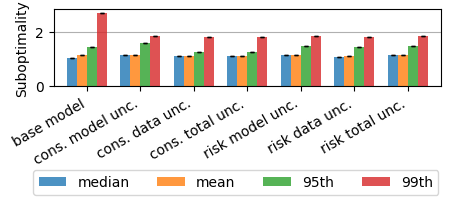

In [758]:
labels = [
   'base model',
   'cons. prun. model unc. SO',
   'cons. prun. data unc. SO',
   'cons. prun. SO',
   'risk prun. model unc. SO', 
   'risk prun. data unc. SO', 
   'risk prun. SO', 
   ]

chart_labels = [
   'base model',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]

rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False

sub = ceb_wlsh_ood_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub_var = ceb_wlsh_ood_agg_res_all_var_df.rename(rename,axis=1).loc[labels,data_points]
# sub.rename(rename,axis=1,inplace=True)
# sub_var.rename(rename,axis=1,inplace=True)
sub.index=chart_labels
sub_var.index=chart_labels
# sub = sub.sort_values(by='99th',ascending=False)

# height_ratios = [0.7,2,2,2]
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.plot.bar(
    logy=logy, figsize=(5,1),
    # secondary_y=['99th'],
    yerr=sub_var,
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(sub.index)),labels=sub.index,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_title('DSB',x=.85,y=.7)
ax.set_ylabel('Suboptimality')

lhandles, llabels = ax3.get_legend_handles_labels()
ax.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.47, -1.5), ncol=4)
# plt.text(x=-1.5,y=-175,s='(a)',fontfamily='serif')

plt.savefig('./plots/ceb_wlsh_subopt_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [759]:
rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th','max']
sub = ceb_wlsh_ood_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub

,median,mean,95th,99th,max
base model,1.054803,1.158554,1.438751,2.679099,3.508272
cons. prun. model unc. SO,1.140248,1.164157,1.586637,1.848281,1.991647
cons. prun. data unc. SO,1.102635,1.126777,1.271843,1.804720,2.000721
cons. prun. SO,1.102635,1.126777,1.271843,1.804720,2.000721
risk prun. model unc. SO,1.140248,1.160370,1.473793,1.848281,1.991647
risk prun. data unc. SO,1.086376,1.129307,1.438403,1.796187,2.000721
risk prun. SO,1.140248,1.159613,1.473793,1.848281,1.991647


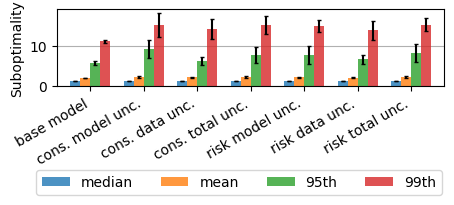

In [760]:
labels = [
   'base model',
   'cons. prun. model unc. SO',
   'cons. prun. data unc. SO',
   'cons. prun. SO',
   'risk prun. model unc. SO', 
   'risk prun. data unc. SO', 
   'risk prun. SO', 
   ]

chart_labels = [
   'base model',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]

rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False

sub = job_main_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub_var = job_main_agg_res_all_var_df.rename(rename,axis=1).loc[labels,data_points]
# sub.rename(rename,axis=1,inplace=True)
# sub_var.rename(rename,axis=1,inplace=True)
sub.index=chart_labels
sub_var.index=chart_labels
# sub = sub.sort_values(by='99th',ascending=False)

# height_ratios = [0.7,2,2,2]
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.plot.bar(
    logy=logy, figsize=(5,1),
    # secondary_y=['99th'],
    yerr=sub_var,
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(sub.index)),labels=sub.index,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_title('DSB',x=.85,y=.7)
ax.set_ylabel('Suboptimality')

lhandles, llabels = ax3.get_legend_handles_labels()
ax.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.47, -1.5), ncol=4)
# plt.text(x=-1.5,y=-175,s='(a)',fontfamily='serif')

plt.savefig('./plots/ceb_wlsh_subopt_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

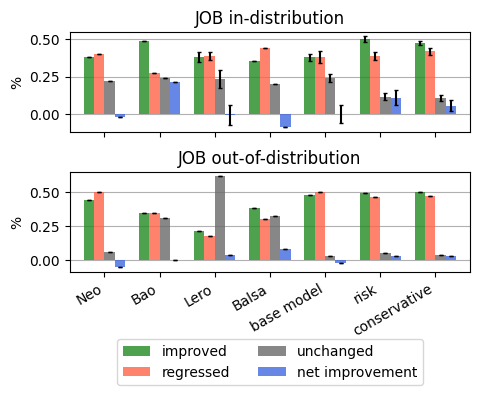

In [761]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

features = ["improved","regressed","unchanged"]

sub = job_main_agg_res_all_df.loc[labels,features]
sub["net improvement"] = sub["improved"]-sub["regressed"]
sub_var = job_main_agg_res_all_var_df.loc[labels,features]
sub_var["net improvement"] = sub_var["improved"]+sub_var["regressed"]

sub1 = job_agg_res_all_df.loc[labels,features]
sub1["net improvement"] = sub1["improved"]-sub1["regressed"]
sub_var1 = job_agg_res_all_var_df.loc[labels,features]
sub_var1["net improvement"] = sub_var1["improved"]+sub_var1["regressed"]

features+=["net improvement"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), sharex=True)

ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('JOB in-distribution')
ax.set_ylabel('%')

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub.index)),labels=sub.index,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB out-of-distribution')
ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
llabels = ["improved","regressed","unchanged","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.2), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

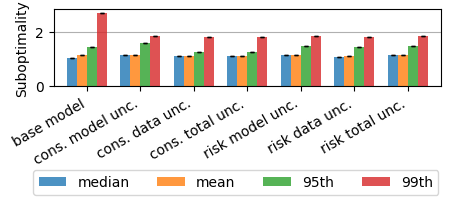

In [762]:
labels = [
   'base model',
   'cons. prun. model unc. SO',
   'cons. prun. data unc. SO',
   'cons. prun. SO',
   'risk prun. model unc. SO', 
   'risk prun. data unc. SO', 
   'risk prun. SO', 
   ]

chart_labels = [
   'base model',
   'cons. model unc.',
   'cons. data unc.',
   'cons. total unc.',
   'risk model unc.',
   'risk data unc.',
   'risk total unc.',
   ]

rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th']
logy=False

sub = ceb_wlsh_ood_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub_var = ceb_wlsh_ood_agg_res_all_var_df.rename(rename,axis=1).loc[labels,data_points]
# sub.rename(rename,axis=1,inplace=True)
# sub_var.rename(rename,axis=1,inplace=True)
sub.index=chart_labels
sub_var.index=chart_labels
# sub = sub.sort_values(by='99th',ascending=False)

# height_ratios = [0.7,2,2,2]
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3.5), sharex=True,gridspec_kw={'height_ratios':height_ratios})

ax=sub.plot.bar(
    logy=logy, figsize=(5,1),
    # secondary_y=['99th'],
    yerr=sub_var,
    align='center', alpha=0.8, ecolor='black', 
    capsize=1.5, width=0.75,
    legend=False
    )

ax.set_xticks(ticks=np.arange(len(sub.index)),labels=sub.index,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_title('DSB',x=.85,y=.7)
ax.set_ylabel('Suboptimality')

lhandles, llabels = ax3.get_legend_handles_labels()
ax.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.47, -1.5), ncol=4)
# plt.text(x=-1.5,y=-175,s='(a)',fontfamily='serif')

plt.savefig('./plots/ceb_wlsh_subopt_bar_mode_data_unc_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [763]:
rename = {'50%':'median', '95%':'95th', '99%':'99th'}
data_points = ['median','mean','95th','99th','max']
sub = ceb_wlsh_ood_agg_res_all_df.rename(rename,axis=1).loc[labels,data_points]
sub

,median,mean,95th,99th,max
base model,1.054803,1.158554,1.438751,2.679099,3.508272
cons. prun. model unc. SO,1.140248,1.164157,1.586637,1.848281,1.991647
cons. prun. data unc. SO,1.102635,1.126777,1.271843,1.804720,2.000721
cons. prun. SO,1.102635,1.126777,1.271843,1.804720,2.000721
risk prun. model unc. SO,1.140248,1.160370,1.473793,1.848281,1.991647
risk prun. data unc. SO,1.086376,1.129307,1.438403,1.796187,2.000721
risk prun. SO,1.140248,1.159613,1.473793,1.848281,1.991647


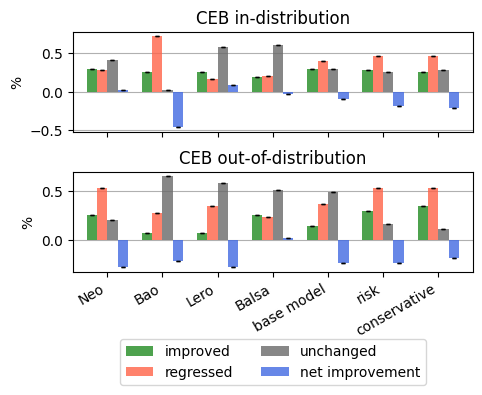

In [764]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

features = ["improved","regressed","unchanged"]

sub = ceb_wlsh_base_agg_res_all_df.loc[labels,features]
sub["net improvement"] = sub["improved"]-sub["regressed"]
sub_var = ceb_wlsh_base_agg_res_all_var_df.loc[labels,features]
sub_var["net improvement"] = sub_var["improved"]+sub_var["regressed"]

sub1 = ceb_wlsh_ood_agg_res_all_df.loc[labels,features]
sub1["net improvement"] = sub1["improved"]-sub1["regressed"]
sub_var1 = ceb_wlsh_ood_agg_res_all_var_df.loc[labels,features]
sub_var1["net improvement"] = sub_var1["improved"]+sub_var1["regressed"]

features+=["net improvement"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), sharex=True)

ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB in-distribution')
ax.set_ylabel('%')

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub1.index)),labels=sub1.index,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('CEB out-of-distribution')
ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
# llabels = ["improved","regressed","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.2), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

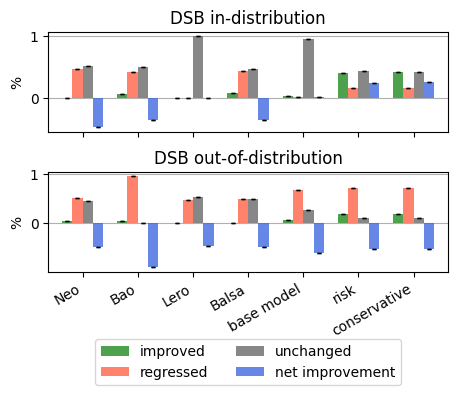

In [765]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

features = ["improved","regressed","unchanged"]

sub = tpcds_ood_base_agg_res_all_df.loc[labels,features]
sub["net improvement"] = sub["improved"]-sub["regressed"]
sub_var = tpcds_ood_base_agg_res_all_var_df.loc[labels,features]
sub_var["net improvement"] = sub_var["improved"]+sub_var["regressed"]

sub1 = tpcds_ood_agg_res_all_df.loc[labels,features]
sub1["net improvement"] = sub1["improved"]-sub1["regressed"]
sub_var1 = tpcds_ood_agg_res_all_var_df.loc[labels,features]
sub_var1["net improvement"] = sub_var1["improved"]+sub_var1["regressed"]

features+=["net improvement"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), sharex=True)

ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('DSB in-distribution')
ax.set_ylabel('%')

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], yerr=sub_var1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub1.index)),labels=sub1.index,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('DSB out-of-distribution')
ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
# llabels = ["improved","regressed","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.2), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

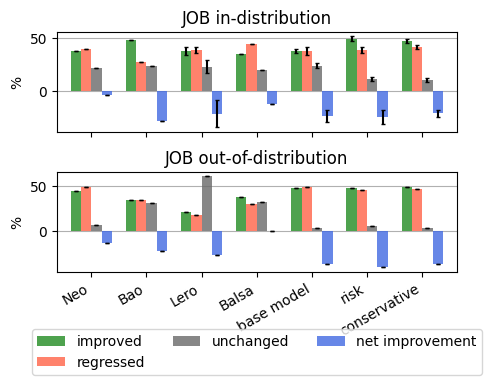

In [766]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

features = ["improved","regressed","unchanged","total_runtime_change%"]

sub = job_main_agg_res_all_df.loc[labels,features]*100
sub_var = job_main_agg_res_all_var_df.loc[labels,features]*100

sub1 = job_agg_res_all_df.loc[labels,features]*100
sub_var1 = job_agg_res_all_var_df.loc[labels,features]*100


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), sharex=True)

ax = sub.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            yerr=sub_var,
            align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('JOB in-distribution')
ax.set_ylabel('%')

ax1 = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            yerr=sub_var1,
            align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub.index)),labels=chart_labels,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB out-of-distribution')
ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
llabels = ["improved","regressed","unchanged","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.1), ncol=3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

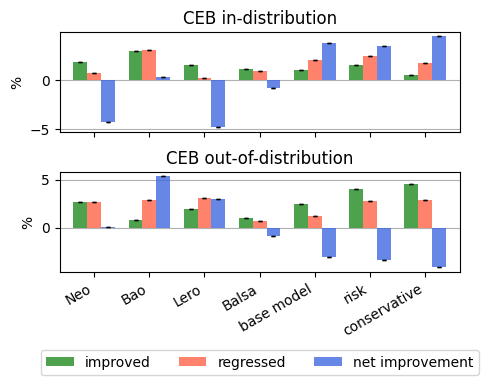

In [767]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'risk',
    'conservative',
    # 'cons. prun. RN',
    # 'cons. prun. SO',
    # 'risk prun. RN',
    # 'risk prun. SO'
    ]

features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = ceb_wlsh_base_agg_res_all_df.loc[labels,features]
sub_var = ceb_wlsh_base_agg_res_all_var_df.loc[labels,features]
sub_perc = sub.copy()
sub_var_perc=sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100
sub_perc.index=chart_labels
sub_var_perc.index=chart_labels

sub1 = ceb_wlsh_ood_agg_res_all_df.loc[labels,features]
sub_var1 = ceb_wlsh_ood_agg_res_all_var_df.loc[labels,features]
sub_perc1 = sub1.copy()
sub_var_perc1=sub_var1.copy()
sub_perc1[["improved_runtime","regressed_runtime"]] = sub_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_var_perc1[["improved_runtime","regressed_runtime"]] = sub_var_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_perc1=sub_perc1*100
sub_var_perc1=sub_var_perc1*100
sub_perc1.index=chart_labels
sub_var_perc1.index=chart_labels


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 3), sharex=True)

ax = sub_perc.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('CEB in-distribution')
ax.set_ylabel('%')

ax1 = sub_perc1.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub_perc.index)),labels=sub_perc.index,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('CEB out-of-distribution')
ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
llabels = ["improved","regressed","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(.5, -1.1), ncol=3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [821]:
# exp_id = 'job_main_5x_10kf_s313'
# exp_id = 'job_main_5x_10kf_s312' # <-- best so far
# exp_id = 'job_main_5x_10kf_s311'
# exp_id = 'job_main_1x_2kf_s313'
# exp_id = 'job_main_1x_10kf_s313' # <-- Bao and Balsa are better
# exp_id = 'job_main_1x_10kf_s316'
# test_split = 'kfoldcv'


model_exp_id = {
    # 'Bao':'job_main_5x_10kf_s313_kfoldcv',
    'Bao':'job_main_1x_10kf_s313_kfoldcv',
    # 'Balsa':'job_main_1x_10kf_s316_kfoldcv',
    'Balsa':'job_main_1x_10kf_s316_kfoldcv',
    'Lero':'job_main_5x_10kf_s312_kfoldcv',
    'Neo':'job_main_5x_10kf_s313_kfoldcv',
    'Roq':'job_main_5x_10kf_s312_kfoldcv',
    # 'Roq':'job_main_1x_10kf_s318_kfoldcv',
}

# Example usage:
job_main_qerror_all_df, job_main_qerror_all_var_df = stitch_res('qerror_dict',model_exp_id)
job_main_corr_all_df, job_main_corr_all_var_df = stitch_res('corr_dict',model_exp_id)
job_main_runtimes_all_df, job_main_runtimes_all_var_df = stitch_res('rt_res_dict',model_exp_id)
job_main_agg_res_all_df, job_main_agg_res_all_var_df = stitch_res('agg_res_dict',model_exp_id)
job_main_so_res_all_df, job_main_so_res_all_var_df = stitch_res('so_res_dict',model_exp_id)


/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/database/config/db2inst1/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


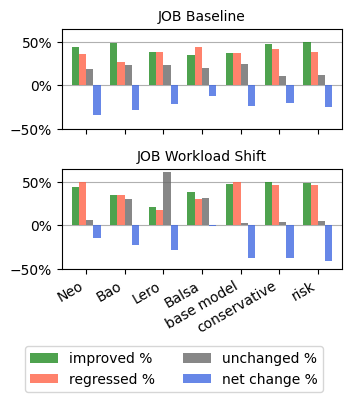

In [822]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'conservative',
    'risk',
    # 'cons. prun. RN',
   #  'cons. prun. SO',
    # 'risk prun. RN',
   #  'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'conservative',
    'risk',
   #  'cons. prun. RN',
   #  'cons. prun. SO',
   #  'risk prun. RN',
   #  'risk prun. SO'
    ]

features = ["improved","regressed","unchanged","total_runtime_change%"]
feature_labels = ["improved %","regressed %","unchanged %","net change %"]


sub1 = job_main_agg_res_all_df.loc[labels,features]*100
sub_var1 = job_main_agg_res_all_var_df.loc[labels,features]*100

sub2 = job_agg_res_all_df.loc[labels,features]*100
sub_var2 = job_agg_res_all_var_df.loc[labels,features]*100


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 3), sharex=True)

ax = sub1.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            # yerr=sub_var1,
            align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('JOB Baseline',fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim((-50,65))
# ax.set_ylabel('%')

ax1 = sub2.plot.bar(logy=False,
            color=['forestgreen','tomato','dimgrey','royalblue'], 
            # yerr=sub_var2,
            align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub1.index)),labels=chart_labels,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB Workload Shift',fontsize=10)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylim((-50,65))
# ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
ax1.legend(lhandles, feature_labels, loc='lower center', bbox_to_anchor=(0.4, -1.3), ncol=2)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.savefig('./plots/job_runtime_bar_wlshift_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

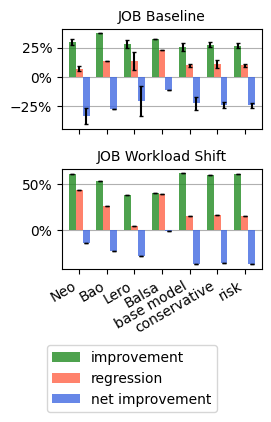

In [823]:
labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
   #  'conservative',
   #  'risk',
    'cons. prun. RN',
   #  'cons. prun. SO',
    'risk prun. RN',
   #  'risk prun. SO'
    ]

chart_labels = [
    # 'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    # 'mc dropout',
    'conservative',
    'risk',
   #  'cons. prun. RN',
   #  'cons. prun. SO',
   #  'risk prun. RN',
   #  'risk prun. SO'
    ]

features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = job_main_agg_res_all_df.loc[labels,features]
sub_var = job_main_agg_res_all_var_df.loc[labels,features]
sub_perc = sub.copy()
sub_var_perc=sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100
sub_perc.index=chart_labels
sub_var_perc.index=chart_labels

sub1 = job_agg_res_all_df.loc[labels,features]
sub_var1 = job_agg_res_all_var_df.loc[labels,features]
sub_perc1 = sub1.copy()
sub_var_perc1=sub_var1.copy()
sub_perc1[["improved_runtime","regressed_runtime"]] = sub_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_var_perc1[["improved_runtime","regressed_runtime"]] = sub_var_perc1[["improved_runtime","regressed_runtime"]]/job_main_runtimes_all_df.optimizer.sum()
sub_perc1=sub_perc1*100
sub_var_perc1=sub_var_perc1*100
sub_perc1.index=chart_labels
sub_var_perc1.index=chart_labels


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 3), sharex=True)

ax = sub_perc.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[0])

ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_title('JOB Baseline',fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_ylabel('%')

ax1 = sub_perc1.plot.bar(logy=False,
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc1,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75,legend = False, ax = axs[1])
ax1.set_xticks(ticks=np.arange(len(sub_perc.index)),labels=sub_perc.index,rotation=30,ha='right')
ax1.grid(visible=True,which='major',axis='y')
ax1.set_axisbelow(True)
ax1.set_title('JOB Workload Shift',fontsize=10)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax1.set_ylabel('%')

lhandles, llabels = ax1.get_legend_handles_labels()
llabels = ["improvement","regression","net improvement"]
ax1.legend(lhandles, llabels, loc='lower center', bbox_to_anchor=(0.35, -1.5), ncol=1)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.savefig('./plots/job_runtime_bar_wlshift_{}.png'.format(plots_id),bbox_inches='tight',dpi=300)
plt.show()

In [824]:
labels=['Bao','Neo',
    'Lero','Balsa',
        'base model','risk','conservative']#,'risk prun. RN','cons. prun. RN','risk prun. SO','cons. prun. SO']
columns = ['improved','regressed']#,'total_runtime_change%']
ood_rt = job_agg_res_all_df.loc[labels,columns]
base_rt = job_main_agg_res_all_df.loc[labels,columns]
ood_rt_var = job_agg_res_all_var_df.loc[labels,columns]
base_rt_var = job_main_agg_res_all_var_df.loc[labels,columns]

columns = ['mean','50%']
ood_so = job_agg_res_all_df.loc[labels,columns]
base_so = job_main_agg_res_all_df.loc[labels,columns]
ood_so_var = job_agg_res_all_var_df.loc[labels,columns]
base_so_var = job_main_agg_res_all_var_df.loc[labels,columns]
ood_so.columns=['mean','median']
base_so.columns=['mean','median']
ood_so_var.columns=['mean','median']
base_so_var.columns=['mean','median']

In [825]:
so_res = pd.concat([base_so,ood_so], axis=1, join="inner",keys=["Baseline", "OOD"])
so_res_var = pd.concat([base_so_var,ood_so_var], axis=1, join="inner",keys=["Baseline", "OOD"])
so_res=so_res.reorder_levels([1,0],axis=1)
so_res=so_res[so_res.columns[[0,2,1,3]]]
so_res_var=so_res_var.reorder_levels([1,0],axis=1)
so_res_var=so_res_var[so_res_var.columns[[0,2,1,3]]]
so_res

mean              median          
              Baseline       OOD  Baseline       OOD
Bao           2.272163  2.524561  1.281113  1.501512
Neo           1.935379  2.775956  1.302123  1.504609
Lero          2.299627  1.979654  1.422176  1.450017
Balsa         2.846430  2.855822  1.534590  1.319392
base model    2.093998  2.145641  1.358522  1.460313
risk          2.091517  2.019223  1.287741  1.416092
conservative  2.184501  2.196760  1.349494  1.441808

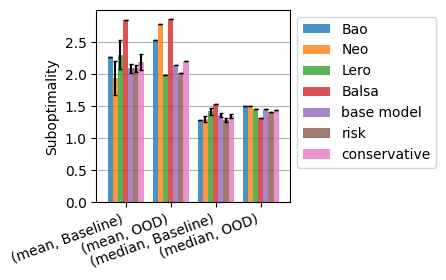

In [826]:
import matplotlib.pyplot as plt
plot_name = './plots/wl_shift_so_bar_job_{}.png'.format(plots_id)

ax = so_res.T.plot.bar(figsize=[2.5,2.5], 
                       yerr=so_res_var.T,
                  align='center', alpha=0.8, ecolor='black', capsize=1.5,
                  width=0.8)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=20,ha='right')
plt.ylabel('Suboptimality')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
if plot_name is not None:
    plt.savefig(plot_name,bbox_inches='tight',dpi=300)

In [827]:
rt_res = pd.concat([base_rt,ood_rt], axis=1, join="inner",keys=["Baseline", "OOD"])
rt_res_var = pd.concat([base_rt_var,ood_rt_var], axis=1, join="inner",keys=["Baseline", "OOD"])
# df.columns=['baseline improved','baseline regressed',
#             'OOD improved', 'OOD regressed']
rt_res*100



Baseline                   OOD           
               improved  regressed   improved  regressed
Bao           48.672566  27.433628  34.513274  34.513274
Neo           44.247788  36.460177  44.247788  49.557522
Lero          38.053097  38.584071  21.238938  17.699115
Balsa         35.398230  44.247788  38.053097  30.088496
base model    37.876106  37.876106  47.787611  49.557522
risk          49.734513  38.761062  48.672566  46.017699
conservative  47.433628  41.769912  49.557522  46.902655

In [828]:
rt_res=rt_res.reorder_levels([1,0],axis=1)
rt_res=rt_res[rt_res.columns[[0,2,1,3]]]
rt_res_var=rt_res_var.reorder_levels([1,0],axis=1)
rt_res_var=rt_res_var[rt_res_var.columns[[0,2,1,3]]]

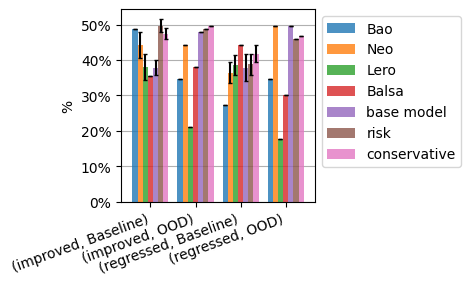

In [829]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plot_name = './plots/wl_shift_runtime_bar_job_{}.png'.format(plots_id)


ax = rt_res.T.plot.bar(figsize=[2.5,2.5], 
                       yerr=rt_res_var.T,
                  align='center', alpha=0.8, ecolor='black', capsize=1.5,
                  width=0.8)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=20,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
# plt.show()
if plot_name is not None:
    plt.savefig(plot_name,bbox_inches='tight',dpi=300)

In [830]:
labels = [
        # 'optimizer pruned',
        'Neo','Bao',
        'Lero','Balsa',
        # 'Neo+','Bao+',
        'base model',#'base model pruned',
        # 'mc dropout','mc dropout pruned',
        'conservative','cons. prun. RN','cons. prun. SO',
        'risk','risk prun. RN','risk prun. SO',
        ]
agg_res_all_df["net improvement"] = agg_res_all_df["improved"]-agg_res_all_df["regressed"]
columns =['improved','regressed','unchanged','net improvement','total_runtime_change%',
          'mean','50%','70%','90%','95%','99%'
          ]

sub = agg_res_all_df.loc[labels,columns].sort_values(by='total_runtime_change%')
# sub[['improved_runtime','regressed_runtime']]=sub[['improved_runtime','regressed_runtime']]/runtimes_all_df.optimizer.sum()
sub

,improved,regressed,unchanged,net improvement,total_runtime_change%,mean,50%,70%,90%,95%,99%
Lero,0.343137,0.176471,0.480392,0.166667,-0.281372,1.941759,1.068510,1.172935,1.557082,3.058239,22.971056
risk prun. SO,0.539216,0.343137,0.117647,0.196078,-0.273663,1.894749,1.077495,1.270832,2.119797,3.158786,10.138052
risk prun. RN,0.539216,0.343137,0.117647,0.196078,-0.273663,1.894749,1.077495,1.270832,2.119797,3.158786,10.138052
risk,0.539216,0.343137,0.117647,0.196078,-0.273663,1.894749,1.077495,1.270832,2.119797,3.158786,10.138052
conservative,0.539216,0.323529,0.137255,0.215686,-0.272998,1.933723,1.054354,1.179012,2.443039,4.041127,10.363719
cons. prun. RN,0.529412,0.333333,0.137255,0.196078,-0.272538,1.933843,1.054354,1.179012,2.443039,4.041127,10.363719
cons. prun. SO,0.529412,0.333333,0.137255,0.196078,-0.272538,1.933843,1.054354,1.179012,2.443039,4.041127,10.363719
base model,0.343137,0.284314,0.372549,0.058824,-0.269380,1.820719,1.087764,1.223134,2.032313,3.437915,11.990779
Bao,0.411765,0.264706,0.323529,0.147059,-0.193975,1.934212,1.046470,1.213877,2.150256,3.942853,27.963618
Balsa,0.441176,0.431373,0.127451,0.009804,-0.145309,1.975703,1.131129,1.431555,2.798215,4.273272,7.564951


In [831]:
job_main_agg_res_all_df["net improvement"] = job_main_agg_res_all_df["improved"]-job_main_agg_res_all_df["regressed"]
sub = job_main_agg_res_all_df.loc[labels,columns].sort_values(by='total_runtime_change%')
sub

,improved,regressed,unchanged,net improvement,total_runtime_change%,mean,50%,70%,90%,95%,99%
Neo,0.442478,0.364602,0.192920,0.077876,-0.340318,1.935379,1.302123,1.620638,2.903782,4.962724,11.364378
Bao,0.486726,0.274336,0.238938,0.212389,-0.282108,2.272163,1.281113,1.550273,2.933513,7.336623,18.962293
risk prun. RN,0.469027,0.394690,0.136283,0.074336,-0.247554,2.290002,1.307338,1.742721,4.013267,7.971562,14.766201
cons. prun. SO,0.479646,0.407080,0.113274,0.072566,-0.247404,2.325033,1.344124,1.782748,4.175045,7.780301,15.038279
risk,0.497345,0.387611,0.115044,0.109735,-0.245552,2.091517,1.287741,1.678662,3.580255,5.733185,13.010141
cons. prun. RN,0.481416,0.398230,0.120354,0.083186,-0.243175,2.230947,1.321840,1.739086,3.642726,7.669082,14.579765
base model,0.378761,0.378761,0.242478,0.000000,-0.231562,2.093998,1.358522,1.766505,3.690723,5.693964,11.070468
risk prun. SO,0.467257,0.401770,0.130973,0.065487,-0.214909,2.341377,1.318583,1.775833,4.233414,8.265798,15.223397
Lero,0.380531,0.385841,0.233628,-0.005310,-0.210411,2.299627,1.422176,1.799584,3.965735,7.184972,14.947765
conservative,0.474336,0.417699,0.107965,0.056637,-0.206060,2.184501,1.349494,1.774091,3.835136,6.493120,14.047090


In [832]:
tpcds_agg_res_all_df["net improvement"] = tpcds_agg_res_all_df["improved"]-tpcds_agg_res_all_df["regressed"]
sub = tpcds_agg_res_all_df.loc[labels,columns].sort_values(by='total_runtime_change%')
sub

,improved,regressed,unchanged,net improvement,total_runtime_change%,mean,50%,70%,90%,95%,99%
base model,0.375000,0.201923,0.423077,0.173077,-0.767842,3.114420,1.278665,1.513680,2.685971,22.998775,31.172418
risk,0.548077,0.201923,0.250000,0.346154,-0.728377,5.077455,1.116068,1.354016,10.904169,16.800367,31.054539
conservative,0.548077,0.211538,0.240385,0.336538,-0.728370,5.077550,1.116068,1.354016,10.904169,16.800367,31.054539
Lero,0.250000,0.355769,0.394231,-0.105769,-0.706219,12.408408,1.286202,1.531858,28.628634,112.891199,117.827536
cons. prun. RN,0.509615,0.259615,0.230769,0.250000,-0.697592,8.576395,1.154120,1.441577,10.904169,19.048078,208.168874
risk prun. RN,0.519231,0.259615,0.221154,0.259615,-0.692985,9.594961,1.136256,1.377151,10.904169,19.048078,208.556838
Neo,0.288462,0.269231,0.442308,0.019231,-0.616292,12.617396,1.248814,2.669652,26.050935,112.891199,117.827536
Balsa,0.259615,0.432692,0.307692,-0.173077,-0.609440,12.926894,1.375472,2.068661,28.628634,112.891199,117.827536
Bao,0.365385,0.413462,0.221154,-0.048077,-0.470305,14.023962,1.370556,10.082488,26.623562,112.891199,117.827536
risk prun. SO,0.086538,0.115385,0.798077,-0.028846,0.027156,5.017387,1.427571,2.241923,10.632755,22.983631,31.053525


In [833]:
agg_res_all_df.index

Index(['Balsa', 'Bao', 'Lero', 'Neo', 'base model', 'base model pruned',
       'best', 'cons. data unc.', 'cons. model unc.', 'cons. prun. RN',
       'cons. prun. SO', 'cons. prun. data unc. RN',
       'cons. prun. data unc. SO', 'cons. prun. model unc. RN',
       'cons. prun. model unc. SO', 'conservative', 'mc dropout',
       'mc dropout pruned', 'optimizer', 'optimizer pruned', 'risk',
       'risk data unc.', 'risk model unc.', 'risk prun. RN', 'risk prun. SO',
       'risk prun. data unc. RN', 'risk prun. data unc. SO',
       'risk prun. model unc. RN', 'risk prun. model unc. SO'],
      dtype='object')

In [834]:
labels = [
    'optimizer',
    'Neo','Bao',
    'Lero','Balsa',
    'base model',
    'base model pruned',
    'risk',
    'conservative',
    'cons. prun. RN',
    'cons. prun. SO',
    'risk prun. RN',
    'risk prun. SO'
    ]
data_points = ['50%','mean','95%','99%']
rn_data_points = ['improved_runtime','regressed_runtime','total_runtime_change%']
df = agg_res_all_df.loc[labels,data_points]
df

,50%,mean,95%,99%
optimizer,1.133255,2.821203,8.245210,31.615361
Neo,1.183174,1.896284,4.279923,10.752974
Bao,1.046470,1.934212,3.942853,27.963618
Lero,1.068510,1.941759,3.058239,22.971056
Balsa,1.131129,1.975703,4.273272,7.564951
base model,1.087764,1.820719,3.437915,11.990779
base model pruned,1.087764,1.820719,3.437915,11.990779
risk,1.077495,1.894749,3.158786,10.138052
conservative,1.054354,1.933723,4.041127,10.363719
cons. prun. RN,1.054354,1.933843,4.041127,10.363719


In [835]:
ceb_so_opt = (df-df.loc['optimizer',:])/df.loc['optimizer',:]
ceb_so_opt


,50%,mean,95%,99%
optimizer,0.000000,0.000000,0.000000,0.000000
Neo,0.044049,-0.327846,-0.480920,-0.659881
Bao,-0.076580,-0.314402,-0.521801,-0.115505
Lero,-0.057132,-0.311727,-0.629089,-0.273421
Balsa,-0.001876,-0.299695,-0.481727,-0.760719
base model,-0.040142,-0.354630,-0.583041,-0.620729
base model pruned,-0.040142,-0.354630,-0.583041,-0.620729
risk,-0.049204,-0.328390,-0.616894,-0.679331
conservative,-0.069624,-0.314575,-0.509882,-0.672194
cons. prun. RN,-0.069624,-0.314533,-0.509882,-0.672194


In [836]:
baseline_models = ['Neo','Bao','Lero','Balsa']
ceb_so_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
ceb_so_ml


,50%,mean,95%,99%
optimizer,0.023421,0.456489,1.120370,0.826090
Neo,0.068501,-0.021015,0.100641,-0.378913
Bao,-0.054953,-0.001434,0.013959,0.615166
Lero,-0.035049,0.002462,-0.213532,0.326798
Balsa,0.021501,0.019986,0.098931,-0.563052
base model,-0.017661,-0.060026,-0.115892,-0.307418
base model pruned,-0.017661,-0.060026,-0.115892,-0.307418
risk,-0.026935,-0.021807,-0.187674,-0.414431
conservative,-0.047834,-0.001687,0.039232,-0.401396
cons. prun. RN,-0.047834,-0.001624,0.039232,-0.401396


In [837]:

df = agg_res_all_df.loc[labels,rn_data_points]
df

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,127.543887,34.895587,-0.137930
Bao,161.115548,30.821338,-0.193975
Lero,205.435935,16.436372,-0.281372
Balsa,231.703264,134.904038,-0.145309
base model,225.783515,44.839261,-0.269380
base model pruned,225.783515,44.839261,-0.269380
risk,231.222609,47.401297,-0.273663
conservative,230.895085,47.520206,-0.272998
cons. prun. RN,230.596014,47.530320,-0.272538


In [838]:
ceb_rn_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
ceb_rn_ml

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,-0.297084,-0.356933,-0.272700
Bao,-0.112065,-0.432015,0.022824
Lero,0.132192,-0.697105,0.483668
Balsa,0.276956,1.486054,-0.233792
base model,0.244331,-0.173688,0.420433
base model pruned,0.244331,-0.173688,0.420433
risk,0.274307,-0.126474,0.443018
conservative,0.272502,-0.124283,0.439514
cons. prun. RN,0.270854,-0.124096,0.437086


In [839]:
df = job_main_agg_res_all_df.loc[labels,data_points]
job_so_opt = (df-df.loc['optimizer',:])/df.loc['optimizer',:]
job_so_opt

,50%,mean,95%,99%
optimizer,0.000000,0.000000,0.000000,0.000000
Neo,-0.094506,-0.149699,-0.388933,-0.197601
Bao,-0.109117,-0.001734,-0.096632,0.338862
Lero,-0.011022,0.010332,-0.115305,0.055410
Balsa,0.067151,0.250568,0.557968,0.291630
base model,-0.055287,-0.080010,-0.298895,-0.218353
base model pruned,0.049530,0.288343,0.418605,0.387090
risk,-0.104508,-0.081100,-0.294066,-0.081399
conservative,-0.061564,-0.040248,-0.200494,-0.008184
cons. prun. RN,-0.080795,-0.019842,-0.055696,0.029427


In [840]:
job_so_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
job_so_ml

,50%,mean,95%,99%
optimizer,0.038285,-0.026638,0.010842,-0.108794
Neo,-0.059840,-0.172349,-0.382308,-0.284897
Bao,-0.075009,-0.028326,-0.086838,0.193201
Lero,0.026842,-0.016581,-0.105713,-0.059413
Balsa,0.108007,0.217255,0.574860,0.151108
base model,-0.019118,-0.104517,-0.291294,-0.303391
base model pruned,0.089711,0.254024,0.433985,0.236183
risk,-0.070224,-0.105578,-0.286412,-0.181337
conservative,-0.025636,-0.065814,-0.191826,-0.116088
cons. prun. RN,-0.045603,-0.045951,-0.045458,-0.082569


In [841]:
df = job_main_agg_res_all_df.loc[labels,rn_data_points]
df

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,203.027717,46.428708,-0.340318
Bao,249.644370,89.305649,-0.282108
Lero,186.550027,89.728315,-0.210411
Balsa,220.434046,154.656351,-0.115733
base model,172.838779,66.284436,-0.231562
base model pruned,142.706686,202.096600,0.129065
risk,185.034219,72.042444,-0.245552
conservative,178.183227,83.363903,-0.206060
cons. prun. RN,185.390875,73.492806,-0.243175


In [842]:
job_rn_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
job_rn_ml

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,-0.055307,-0.511430,0.435079
Bao,0.161601,-0.060235,0.189614
Lero,-0.131978,-0.055787,-0.112722
Balsa,0.025685,0.627452,-0.511970
base model,-0.195777,-0.302488,-0.023532
base model pruned,-0.335982,1.126667,-1.544251
risk,-0.139031,-0.241896,0.035461
conservative,-0.170909,-0.122760,-0.131072
cons. prun. RN,-0.137372,-0.226634,0.025438


In [843]:
df = tpcds_agg_res_all_df.loc[labels,data_points]
tpcds_so_opt = (df-df.loc['optimizer',:])/df.loc['optimizer',:]
tpcds_so_opt
# (df-df.max())/df.max()


,50%,mean,95%,99%
optimizer,0.000000,0.000000,0.000000,0.000000
Neo,-0.084153,1.540625,3.623898,2.779865
Bao,0.005130,1.823850,3.623898,2.779865
Lero,-0.056733,1.498544,3.623898,2.779865
Balsa,0.008735,1.602945,3.623898,2.779865
base model,-0.062260,-0.372884,-0.057996,0.000000
base model pruned,0.109603,1.714001,3.623898,2.779865
risk,-0.181505,0.022391,-0.311876,-0.003782
conservative,-0.181505,0.022410,-0.311876,-0.003782
cons. prun. RN,-0.153599,0.726934,-0.219812,5.677983


In [844]:
tpcds_so_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
tpcds_so_ml

,50%,mean,95%,99%
optimizer,0.032797,-0.617809,-0.783732,-0.735440
Neo,-0.054116,-0.028995,0.000000,0.000000
Bao,0.038095,0.079251,0.000000,0.000000
Lero,-0.025797,-0.045078,0.000000,0.000000
Balsa,0.041818,-0.005177,0.000000,0.000000
base model,-0.031506,-0.760322,-0.796275,-0.735440
base model pruned,0.145994,0.037267,0.000000,0.000000
risk,-0.154661,-0.609251,-0.851181,-0.736441
conservative,-0.154661,-0.609244,-0.851181,-0.736441
cons. prun. RN,-0.125840,-0.339981,-0.831270,0.766725


In [845]:
df = tpcds_agg_res_all_df.loc[labels,rn_data_points]
df

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,45.842508,10.389652,-0.616292
Bao,45.704982,18.650166,-0.470305
Lero,45.548961,4.922910,-0.706219
Balsa,45.626413,10.567686,-0.609440
base model,45.723442,1.552473,-0.767842
base model pruned,0.515298,4.321584,0.066166
risk,45.815182,3.914493,-0.728377
conservative,45.815182,3.914896,-0.728370
cons. prun. RN,45.678701,5.548939,-0.697592


In [846]:
tpcds_rn_ml = (df-df.loc[baseline_models,:].mean())/df.loc[baseline_models,:].mean()
tpcds_rn_ml

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,0.003542,-0.066737,0.026188
Bao,0.000531,0.675274,-0.216895
Lero,-0.002884,-0.557793,0.175927
Balsa,-0.001189,-0.050744,0.014780
base model,0.000935,-0.860547,0.278535
base model pruned,-0.988720,-0.611808,-1.110173
risk,0.002944,-0.648376,0.212821
conservative,0.002944,-0.648340,0.212810
cons. prun. RN,-0.000044,-0.501560,0.161562


In [847]:
so_vs_opt = (ceb_so_opt+job_so_opt+tpcds_so_opt)/3
so_vs_opt

,50%,mean,95%,99%
optimizer,0.000000,0.000000,0.000000,0.000000
Neo,-0.044870,0.354360,0.918015,0.640794
Bao,-0.060189,0.502571,1.001822,1.001074
Lero,-0.041629,0.399050,0.959835,0.853951
Balsa,0.024670,0.517939,1.233380,0.770259
base model,-0.052563,-0.269175,-0.313311,-0.279694
base model pruned,0.039664,0.549238,1.153154,0.848742
risk,-0.111739,-0.129033,-0.407612,-0.254837
conservative,-0.104231,-0.110804,-0.340750,-0.228053
cons. prun. RN,-0.101339,0.130853,-0.261797,1.678405


In [848]:
(so_vs_opt.loc[['risk','conservative']] - so_vs_opt.loc['base model'])/so_vs_opt.loc['base model']

,50%,mean,95%,99%
risk,1.125811,-0.520635,0.300984,-0.088871
conservative,0.982978,-0.588355,0.087581,-0.184634


In [849]:
so_vs_ml = (ceb_so_ml+job_so_ml+tpcds_so_ml)/3
so_vs_ml

,50%,mean,95%,99%
optimizer,0.031501,-0.062653,0.115827,-0.006048
Neo,-0.015151,-0.074120,-0.093889,-0.221270
Bao,-0.030622,0.016497,-0.024293,0.269456
Lero,-0.011335,-0.019732,-0.106415,0.089129
Balsa,0.057109,0.077355,0.224597,-0.137314
base model,-0.022762,-0.308288,-0.401154,-0.448750
base model pruned,0.072681,0.077088,0.106031,-0.023745
risk,-0.083940,-0.245545,-0.441756,-0.444070
conservative,-0.076044,-0.225581,-0.334592,-0.417975
cons. prun. RN,-0.073092,-0.129186,-0.279166,0.094253


In [850]:
rn_vs_ml = (ceb_rn_ml+job_rn_ml+tpcds_rn_ml)/3
rn_vs_ml


,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,-0.116283,-0.311700,0.062855
Bao,0.016689,0.061008,-0.001485
Lero,-0.000890,-0.436895,0.182291
Balsa,0.100484,0.687587,-0.243661
base model,0.016497,-0.445574,0.225145
base model pruned,-0.360124,0.113723,-0.744664
risk,0.046073,-0.338915,0.230433
conservative,0.034845,-0.298461,0.173750
cons. prun. RN,0.044479,-0.284097,0.208029


## Step plots

In [851]:
# def plot_step_curve(arrays, titles, scale='log', title='Workload Runtime', mask=None, figsize=[10,6],
#                     save_to=None, bbox_to_anchor=None, show_fig=True, legend=True,ncol=1, ax=None):
#     for idx, array in enumerate(arrays):
#         if mask is not None:
#             array = array[mask]
#         x = np.arange(array.shape[0])
#         y = array.cumsum()
#         ax.step(x, y + 2, label=titles[idx])  # Use the ax object to plot
#     ax.set_yscale(scale)
#     ax.grid(axis='x', color='0.95')
#     if legend:
#         ax.legend(bbox_to_anchor=bbox_to_anchor, ncol=ncol)
#     ax.set_title(title, fontsize=10)
#     ax.set_xlabel('Queries')
#     ax.set_ylabel('Runtime (s)')
#     if save_to is not None:
#         fig.savefig(save_to, bbox_inches='tight', dpi=300)
#     if show_fig:
#         plt.show()
#     return ax  # Return the axis object


In [852]:
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 3), sharex=True,show_fig=True)

In [853]:
# labels = [
#     'optimizer',#'optimizer pruned',
#     'Neo','Bao',
#     'Lero','Balsa',
#     'base model',
#     'conservative',#'cons. prun. RN',
#     'risk',#'risk prun. RN',
#     'best'
#     ]

# values = job_main_runtimes_all_df.loc[:,labels].sort_index().values.T

# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 3), sharex=True)

# fig,ax0 = plot_step_curve(
#     values,labels,scale='linear',figsize=[3,1.5],title='JOB Baseline',
#     bbox_to_anchor=(1.0, 1.0),
#     show_fig=False, legend=False, ax=axs[0])

# values = job_runtimes_all_df.loc[:,labels].sort_index().values.T

# fig,ax1=plot_step_curve(
#     values,labels,scale='linear',figsize=[3,1.5], title='JOB Workload Shift',
#     show_fig=False,
#     bbox_to_anchor=(1, -.4),ncol=2,ax=axs[1])

# fig.savefig(save_to='./plots/rt_job_step_ext_wlshift_{}.png'.format(plots_id), bbox_inches='tight', dpi=300)
# fig.show()


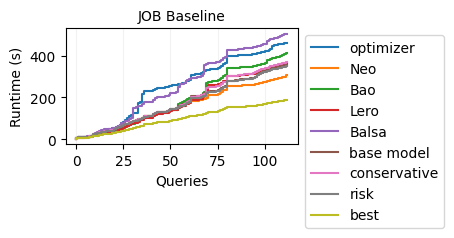

In [854]:
labels = [
                 'optimizer',#'optimizer pruned',
                 'Neo','Bao',
                'Lero','Balsa',
                #  'Neo+','Bao+',
                 'base model',
                # #'base model pruned',
                #  'mc dropout',
                 'conservative',#'cons. prun. RN',
                 'risk',#'risk prun. RN',
                'best'
                ]

values = job_main_runtimes_all_df.loc[:,labels].sort_index().values.T

ax1 = plot_step_curve(
    values,labels,scale='linear',figsize=[3,1.5],title='JOB Baseline',
    save_to='./plots/runtime_step_ext_base_{}.png'.format(plots_id),bbox_to_anchor=(1.0, 1.0),show_fig=show_fig, legend=True)

In [861]:
job_main_agg_res_all_df

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,...,mean,50%,60%,70%,80%,90%,95%,99%,max,net improvement
Balsa,0.353982,220.434046,5.510851,0.442478,154.656351,3.093127,0.203540,-0.115733,-65.777695,-0.582103,...,2.846430,1.534590,1.665147,2.126207,2.971541,5.415297,12.652903,18.293352,19.042013,-0.088496
Bao,0.486726,249.644370,4.538989,0.274336,89.305649,2.880827,0.238938,-0.282108,-160.338721,-1.418927,...,2.272163,1.281113,1.421576,1.550273,1.821139,2.933513,7.336623,18.962293,20.070972,0.212389
Lero,0.380531,186.550027,4.341156,0.385841,89.728315,2.011246,0.233628,-0.210411,-96.821713,-0.856829,...,2.299627,1.422176,1.570919,1.799584,2.367150,3.965735,7.184972,14.947765,16.374462,-0.005310
Neo,0.442478,203.027717,4.075880,0.364602,46.428708,1.123273,0.192920,-0.340318,-156.599009,-1.385832,...,1.935379,1.302123,1.454321,1.620638,1.834907,2.903782,4.962724,11.364378,16.312004,0.077876
base model,0.378761,172.838779,4.059571,0.378761,66.284436,1.556991,0.242478,-0.231562,-106.554343,-0.942959,...,2.093998,1.358522,1.551394,1.766505,2.290056,3.690723,5.693964,11.070468,14.488703,0.000000
base model pruned,0.348673,142.706686,3.587603,0.446018,202.096600,3.955833,0.205310,0.129065,59.389914,0.525574,...,2.932409,1.509251,1.720159,2.028584,2.950571,6.416515,11.521073,19.645355,25.410679,-0.097345
best,0.973451,272.308617,2.475533,0.000000,0.000000,0.000000,0.026549,-0.591777,-272.308617,-2.409811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973451
cons. data unc.,0.474336,178.821003,3.335739,0.415929,83.413556,1.767417,0.109735,-0.207338,-95.407446,-0.844314,...,2.205861,1.350223,1.549863,1.764801,2.323646,3.790665,6.620827,14.545493,16.755009,0.058407
cons. model unc.,0.492035,190.253573,3.424012,0.391150,62.437952,1.422747,0.116814,-0.277767,-127.815620,-1.131112,...,2.169822,1.279449,1.419559,1.655896,2.095656,3.669854,7.426871,14.053421,17.001257,0.100885
cons. prun. RN,0.481416,185.390875,3.405893,0.398230,73.492806,1.615663,0.120354,-0.243175,-111.898069,-0.990248,...,2.230947,1.321840,1.506210,1.739086,2.253620,3.642726,7.669082,14.579765,17.306475,0.083186


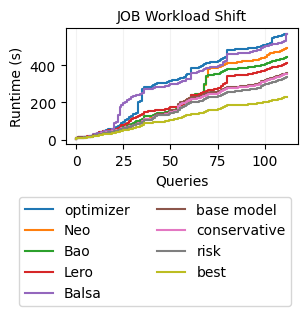

In [855]:
labels = [
                 'optimizer',#'optimizer pruned',
                 'Neo','Bao',
                'Lero','Balsa',
                #  'Neo+','Bao+',
                 'base model',
                # #'base model pruned',
                #  'mc dropout',
                 'conservative',#'cons. prun. RN',
                 'risk',#'risk prun. RN',
                'best'
                ]

values = job_runtimes_all_df.loc[:,labels].sort_index().values.T

plot_step_curve(values,labels,scale='linear',figsize=[3,1.5], title='JOB Workload Shift',
                save_to='./plots/runtime_step_ext_wlshift_{}.png'.format(plots_id),show_fig=show_fig,
                bbox_to_anchor=(1, -.4),ncol=2)

In [856]:
job_main_runtimes_all_df.sum(axis=0).sort_values(ascending=True)


best                         187.845817
Neo                          303.555425
cons. model unc.             332.338814
cons. prun. model unc. SO    338.428939
cons. prun. model unc. RN    339.265796
risk prun. model unc. SO     339.847395
risk model unc.              342.842108
mc dropout                   345.795165
risk prun. RN                346.241498
cons. prun. SO               346.310394
risk data unc.               347.109934
risk                         347.162659
cons. prun. RN               348.256365
risk prun. data unc. RN      348.684556
mc dropout pruned            348.825250
base model                   353.600091
risk prun. data unc. SO      356.511373
risk prun. SO                361.263086
cons. prun. data unc. SO     361.633292
Lero                         363.332721
cons. prun. data unc. RN     364.280852
cons. data unc.              364.746988
conservative                 365.335110
Bao                          408.020392
risk prun. model unc. RN     427.246809


In [857]:
job_runtimes_all_df.sum(axis=0).sort_values(ascending=True)

best                         228.316432
risk data unc.               333.941716
risk prun. model unc. RN     333.941716
risk                         334.606247
risk prun. data unc. SO      336.974411
risk prun. data unc. RN      336.974411
base model pruned            348.157055
risk model unc.              352.776901
cons. prun. model unc. RN    353.230823
cons. data unc.              353.230823
conservative                 353.230823
cons. prun. data unc. RN     353.230823
cons. model unc.             353.230823
mc dropout                   353.230823
cons. prun. SO               353.941737
cons. prun. data unc. SO     353.941737
cons. prun. model unc. SO    356.296116
base model                   357.213806
risk prun. model unc. SO     357.394481
risk prun. SO                358.535668
mc dropout pruned            358.560550
risk prun. RN                358.761341
cons. prun. RN               363.629162
Lero                         410.917446
Bao                          441.802868


In [858]:
# sum_rn_ml = ceb_rn_ml.copy()
sum_rn_ml = pd.DataFrame(
    np.array([ceb_rn_ml,job_rn_ml,tpcds_rn_ml]).min(axis=2).T,
    columns=ceb_rn_ml.columns,index=ceb_rn_ml.index)
sum_rn_ml

,improved_runtime,regressed_runtime,total_runtime_change%
optimizer,NaN,NaN,NaN
Neo,-0.356933,-0.511430,-0.066737
Bao,-0.432015,-0.060235,-0.216895
Lero,-0.697105,-0.131978,-0.557793
Balsa,-0.233792,-0.511970,-0.050744
base model,-0.173688,-0.302488,-0.860547
base model pruned,-0.173688,-1.544251,-1.110173
risk,-0.126474,-0.241896,-0.648376
conservative,-0.124283,-0.170909,-0.648340
cons. prun. RN,-0.124096,-0.226634,-0.501560
